Trey Tuscai and Gordon Doore

Spring 2025

CS 444: Deep Learning

Project 1: Deep Neural Networks 

#### Week 4: Batch normalization and learning rate decay

The continued focus this week is on strategies for training deep neural networks.

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

plt.style.use(['seaborn-v0_8-colorblind', 'seaborn-v0_8-darkgrid'])
plt.rcParams.update({'font.size': 20})

np.set_printoptions(suppress=True, precision=4)

# Automatically reload your external source code
%load_ext autoreload
%autoreload 2

2025-03-05 02:03:28.855104: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-05 02:03:33.576870: I tensorflow/core/platform/cpu_feature_guard.cc:211] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Task 9. Batch normalization

Batch normalization is one of the most powerful techniques for effectively training very deep neural networks. Let's implement batch normalization in the deep learning library and experiment with how integrating it with VGG networks affects classification accuracy on CIFAR-10.

### 9a. Implement batch normalization

Implement the following methods / make the following changes:

**Layer:**
- Constructor: If you have not already done so, make instance variables for the two batch normalization related parameters.
- `is_doing_batchnorm`
- `init_batchnorm_params`: Initialize the batch normalization parameters. The gain, bias, mean, and standard deviation.
- `__call__`: Update how you compute the forward pass through the layer. If we are doing batch norm AND the batch norm moving mean is not `None`, perform batch normalization on the net input before the layer's activation is computed.

**Dense**:
- `compute_batch_norm(net_in, eps=0.001)`: Updates the running mini-batch mean and standard deviation during training and performs batch normalization on the net input signal.

**Conv2D**:
- `compute_batch_norm(net_in, eps=0.001)`: Updates the running mini-batch mean and standard deviation during training and performs batch normalization on the net input signal.

**VGGConvBlock** and **VGGDenseBlock**:
- In the constructors, pass along the `do_batch_norm` parameter to constituent layers.

#### Test: `Dense` batch norm

In [64]:
from layers import Dense

In [65]:
print(30*'-', 'Test: Dense w/ linear (not training)', 30*'-')

tf.random.set_seed(0)
dense = Dense('Test', units=5, prev_layer_or_block=None, wt_init='he', activation='linear', do_batch_norm=True)
dense(tf.ones([1, 3]))
dense.init_batchnorm_params()

tf.random.set_seed(1)
net_acts = dense(tf.random.uniform([2, 3]))
print(f'Your net_acts (not in training mode) are\n{net_acts}')
print('They should be:')
print('''[[ 0.1316 -0.1246  0.867  -0.0392 -0.1553]
 [ 0.1964 -0.0568  0.3891 -0.4167 -0.5647]]''')

print(30*'-', 'Test: Dense w/ ReLU (not training)', 30*'-')

tf.random.set_seed(0)
dense = Dense('Test', units=5, prev_layer_or_block=None, wt_init='he', do_batch_norm=True)
dense(tf.ones([1, 3]))
dense.init_batchnorm_params()

tf.random.set_seed(1)
net_acts = dense(tf.random.uniform([2, 3]))
print(f'Your net_acts (not in training mode) are\n{net_acts}')
print('They should be:')
print('''[[0.1861 0.     1.2261 0.     0.    ]
 [0.2777 0.     0.5503 0.     0.    ]]''')

------------------------------ Test: Dense w/ linear (not training) ------------------------------
Your net_acts (not in training mode) are
[[ 0.1316 -0.1246  0.867  -0.0392 -0.1553]
 [ 0.1964 -0.0568  0.3891 -0.4167 -0.5647]]
They should be:
[[ 0.1316 -0.1246  0.867  -0.0392 -0.1553]
 [ 0.1964 -0.0568  0.3891 -0.4167 -0.5647]]
------------------------------ Test: Dense w/ ReLU (not training) ------------------------------
Your net_acts (not in training mode) are
[[0.1861 0.     1.2261 0.     0.    ]
 [0.2777 0.     0.5503 0.     0.    ]]
They should be:
[[0.1861 0.     1.2261 0.     0.    ]
 [0.2777 0.     0.5503 0.     0.    ]]


In [66]:
print(30*'-', 'Test: Dense w/ linear (training)', 30*'-')
tf.random.set_seed(0)
dense = Dense('Test', units=4, prev_layer_or_block=None, wt_init='he', activation='linear', do_batch_norm=True)
dense(tf.ones([1, 6]))
dense.init_batchnorm_params()

dense.set_mode(True)

tf.random.set_seed(1)
net_acts = dense(tf.random.uniform([3, 6]))
print(f'Your net_acts (in training mode) are\n{net_acts}')
print('They should be:')
print('''[[-1.2303  1.1081 -0.1128  1.1738]
 [ 1.2109  0.16   -1.1564 -1.2605]
 [ 0.0194 -1.2681  1.2692  0.0866]]''')

print(30*'-', 'Test: Dense w/ ReLU (training)', 30*'-')
tf.random.set_seed(0)
dense = Dense('Test', units=5, prev_layer_or_block=None, wt_init='he', do_batch_norm=True)
dense(tf.ones([1, 3]))
dense.init_batchnorm_params()

dense.set_mode(True)

tf.random.set_seed(1)
net_acts = dense(tf.random.uniform([2, 3]))
print(f'Your net_acts (in training mode) are\n{net_acts}')
print('They should be:')
print('''[[0.     0.     0.9971 0.9963 0.9966]
 [0.9787 0.9796 0.     0.     0.    ]]''')

------------------------------ Test: Dense w/ linear (training) ------------------------------
Your net_acts (in training mode) are
[[-1.2303  1.1081 -0.1128  1.1738]
 [ 1.2109  0.16   -1.1564 -1.2605]
 [ 0.0194 -1.2681  1.2692  0.0866]]
They should be:
[[-1.2303  1.1081 -0.1128  1.1738]
 [ 1.2109  0.16   -1.1564 -1.2605]
 [ 0.0194 -1.2681  1.2692  0.0866]]
------------------------------ Test: Dense w/ ReLU (training) ------------------------------
Your net_acts (in training mode) are
[[0.     0.     0.9971 0.9963 0.9966]
 [0.9787 0.9796 0.     0.     0.    ]]
They should be:
[[0.     0.     0.9971 0.9963 0.9966]
 [0.9787 0.9796 0.     0.     0.    ]]


In [67]:
print(30*'-', 'Test: Dense w/ ReLU multiple mini-batches', 30*'-')
tf.random.set_seed(0)
dense = Dense('Test', units=5, prev_layer_or_block=None, wt_init='he', do_batch_norm=True)
dense(tf.ones([1, 3]))
dense.init_batchnorm_params()

dense.set_mode(True)

tf.random.set_seed(1)
for i in range(5):
    net_acts = dense(tf.random.uniform([2, 3]))
print(f'Your net_acts after some mini-batches are\n{net_acts}')
print('They should be:')
print('''[[0.9975 0.9953 0.     0.     0.    ]
 [0.     0.     0.9984 0.9953 0.9946]]''')

dense.set_mode(False)

tf.random.set_seed(2)
net_acts1 = dense(tf.random.uniform([2, 3]))
net_acts2 = dense(tf.random.uniform([2, 3]))

print('After processing mini-batches in non-training mode, the net_acts are:')
print(net_acts1.numpy())
print(net_acts2.numpy())
print('and should be:')
print('''[[0.2089 0.     0.5334 0.     0.    ]
 [0.2175 0.     1.505  0.     0.    ]]
[[0.8584 0.0224 1.0932 0.     0.    ]
 [1.1234 0.2351 0.2997 0.     0.    ]]''')


------------------------------ Test: Dense w/ ReLU multiple mini-batches ------------------------------
Your net_acts after some mini-batches are
[[0.9975 0.9953 0.     0.     0.    ]
 [0.     0.     0.9984 0.9953 0.9946]]
They should be:
[[0.9975 0.9953 0.     0.     0.    ]
 [0.     0.     0.9984 0.9953 0.9946]]
After processing mini-batches in non-training mode, the net_acts are:
[[0.2089 0.     0.5334 0.     0.    ]
 [0.2175 0.     1.505  0.     0.    ]]
[[0.8584 0.0224 1.0932 0.     0.    ]
 [1.1234 0.2351 0.2997 0.     0.    ]]
and should be:
[[0.2089 0.     0.5334 0.     0.    ]
 [0.2175 0.     1.505  0.     0.    ]]
[[0.8584 0.0224 1.0932 0.     0.    ]
 [1.1234 0.2351 0.2997 0.     0.    ]]


#### Test: `Conv2D` batch norm

In [68]:
from layers import Conv2D

In [69]:
print(30*'-', 'Test: Conv2D w/ linear (not training)', 30*'-')

tf.random.set_seed(0)
conv = Conv2D('Test', units=4, kernel_size=(2, 2), prev_layer_or_block=None, wt_init='he', activation='linear',
              do_batch_norm=True)
conv(tf.ones([1, 2, 2, 3]))
conv.init_batchnorm_params()

tf.random.set_seed(1)
net_acts = conv(tf.random.uniform([2, 2, 2, 3]))
print(f'Your net_acts (not in training mode) are\n{net_acts}')
print('They should be:')
print('''[[[[-0.4583  0.3257 -0.7078 -0.3702]
   [-0.1189  0.2832 -0.1614 -0.0745]]

  [[ 0.4845  0.4109 -0.5069 -0.2724]
   [ 0.1433  0.2664 -0.2008 -0.0392]]]


 [[[-0.2477  0.4331 -0.2983 -0.2121]
   [-0.0728  0.2052 -0.1844  0.1303]]

  [[ 0.2266  0.4893 -0.3521 -0.0567]
   [ 0.0542  0.0702 -0.0703 -0.0319]]]]''')

------------------------------ Test: Conv2D w/ linear (not training) ------------------------------
Your net_acts (not in training mode) are
[[[[-0.4583  0.3257 -0.7078 -0.3702]
   [-0.1189  0.2832 -0.1614 -0.0745]]

  [[ 0.4845  0.4109 -0.5069 -0.2724]
   [ 0.1433  0.2664 -0.2008 -0.0392]]]


 [[[-0.2477  0.4331 -0.2983 -0.2121]
   [-0.0728  0.2052 -0.1844  0.1303]]

  [[ 0.2266  0.4893 -0.3521 -0.0567]
   [ 0.0542  0.0702 -0.0703 -0.0319]]]]
They should be:
[[[[-0.4583  0.3257 -0.7078 -0.3702]
   [-0.1189  0.2832 -0.1614 -0.0745]]

  [[ 0.4845  0.4109 -0.5069 -0.2724]
   [ 0.1433  0.2664 -0.2008 -0.0392]]]


 [[[-0.2477  0.4331 -0.2983 -0.2121]
   [-0.0728  0.2052 -0.1844  0.1303]]

  [[ 0.2266  0.4893 -0.3521 -0.0567]
   [ 0.0542  0.0702 -0.0703 -0.0319]]]]


In [70]:
print(30*'-', 'Test: Conv2D w/ linear (training)', 30*'-')

tf.random.set_seed(0)
conv = Conv2D('Test', units=4, kernel_size=(2, 2), prev_layer_or_block=None, wt_init='he', activation='linear',
              do_batch_norm=True)
conv(tf.ones([1, 2, 2, 3]))
conv.init_batchnorm_params()

conv.set_mode(True)

tf.random.set_seed(1)
net_acts = conv(tf.random.uniform([2, 2, 2, 3]))
print(f'Your net_acts (not in training mode) are\n{net_acts}')
print('They should be:')
print('''[[[[-1.6719  0.1188 -2.0219 -1.6977]
   [-0.4375 -0.2133  0.7571  0.2757]]

  [[ 1.7572  0.7852 -1.     -1.0448]
   [ 0.5163 -0.3449  0.5564  0.5117]]]


 [[[-0.9058  0.9583  0.0608 -0.6427]
   [-0.2695 -0.8235  0.64    1.6431]]

  [[ 0.8191  1.3981 -0.2129  0.3946]
   [ 0.1922 -1.8786  1.2204  0.5601]]]]''')


------------------------------ Test: Conv2D w/ linear (training) ------------------------------
Your net_acts (not in training mode) are
[[[[-1.6719  0.1188 -2.0219 -1.6977]
   [-0.4375 -0.2133  0.7571  0.2757]]

  [[ 1.7572  0.7852 -1.     -1.0448]
   [ 0.5163 -0.3449  0.5564  0.5117]]]


 [[[-0.9058  0.9583  0.0608 -0.6427]
   [-0.2695 -0.8235  0.64    1.6431]]

  [[ 0.8191  1.3981 -0.2129  0.3946]
   [ 0.1922 -1.8786  1.2204  0.5601]]]]
They should be:
[[[[-1.6719  0.1188 -2.0219 -1.6977]
   [-0.4375 -0.2133  0.7571  0.2757]]

  [[ 1.7572  0.7852 -1.     -1.0448]
   [ 0.5163 -0.3449  0.5564  0.5117]]]


 [[[-0.9058  0.9583  0.0608 -0.6427]
   [-0.2695 -0.8235  0.64    1.6431]]

  [[ 0.8191  1.3981 -0.2129  0.3946]
   [ 0.1922 -1.8786  1.2204  0.5601]]]]


In [71]:
print(30*'-', 'Test: Conv2D w/ ReLU multiple mini-batches', 30*'-')
tf.random.set_seed(0)
conv = Conv2D('Test', units=4, kernel_size=(2, 2), prev_layer_or_block=None, wt_init='he', do_batch_norm=True)
conv(tf.ones([1, 2, 2, 3]))
conv.init_batchnorm_params()

conv.set_mode(True)

tf.random.set_seed(1)
for i in range(5):
    net_acts = conv(tf.random.uniform([2, 2, 2, 3]))
print(f'Your net_acts after some mini-batches are\n{net_acts}')
print('They should be:')
print('''[[[[0.     0.     0.252  0.    ]
   [0.     0.1891 1.3142 0.4295]]

  [[1.1739 0.     0.0018 0.4892]
   [0.7065 0.     0.2646 0.7403]]]


 [[[0.     1.7817 0.     0.    ]
   [0.     0.447  0.8604 0.5298]]

  [[1.1745 0.8703 0.     0.5416]
   [0.7664 0.     0.2116 0.6486]]]]''')

------------------------------ Test: Conv2D w/ ReLU multiple mini-batches ------------------------------
Your net_acts after some mini-batches are
[[[[0.     0.     0.252  0.    ]
   [0.     0.1891 1.3142 0.4295]]

  [[1.1739 0.     0.0018 0.4892]
   [0.7065 0.     0.2646 0.7403]]]


 [[[0.     1.7817 0.     0.    ]
   [0.     0.447  0.8604 0.5298]]

  [[1.1745 0.8703 0.     0.5416]
   [0.7664 0.     0.2116 0.6486]]]]
They should be:
[[[[0.     0.     0.252  0.    ]
   [0.     0.1891 1.3142 0.4295]]

  [[1.1739 0.     0.0018 0.4892]
   [0.7065 0.     0.2646 0.7403]]]


 [[[0.     1.7817 0.     0.    ]
   [0.     0.447  0.8604 0.5298]]

  [[1.1745 0.8703 0.     0.5416]
   [0.7664 0.     0.2116 0.6486]]]]


In [72]:
conv.set_mode(False)

tf.random.set_seed(2)
for i in range(2):
    net_acts = conv(tf.random.uniform([2, 2, 2, 3]))

print('After processing mini-batches in non-training mode, the net_acts are:')
print(net_acts.numpy())
print('and should be:')
print('''[[[[0.     0.0107 0.     0.    ]
   [0.     0.2271 0.3021 0.    ]]

  [[0.0629 0.0541 0.     0.0349]
   [0.     0.3308 0.     0.1565]]]


 [[[0.     0.4355 0.     0.    ]
   [0.     0.     0.2244 0.4117]]

  [[0.0396 0.2184 0.     0.058 ]
   [0.4179 0.3454 0.     0.    ]]]]''')


After processing mini-batches in non-training mode, the net_acts are:
[[[[0.     0.0107 0.     0.    ]
   [0.     0.2271 0.3021 0.    ]]

  [[0.0629 0.0541 0.     0.0349]
   [0.     0.3308 0.     0.1565]]]


 [[[0.     0.4355 0.     0.    ]
   [0.     0.     0.2244 0.4117]]

  [[0.0396 0.2184 0.     0.058 ]
   [0.4179 0.3454 0.     0.    ]]]]
and should be:
[[[[0.     0.0107 0.     0.    ]
   [0.     0.2271 0.3021 0.    ]]

  [[0.0629 0.0541 0.     0.0349]
   [0.     0.3308 0.     0.1565]]]


 [[[0.     0.4355 0.     0.    ]
   [0.     0.     0.2244 0.4117]]

  [[0.0396 0.2184 0.     0.058 ]
   [0.4179 0.3454 0.     0.    ]]]]


### 9b. Create VGG networks that use batch normalization

In `vgg_nets.py`, create the `VGG4Plus`, `VGG15Plus`, and `VGG15PlusPlus` networks. These are the same as the corresponding nets you have already implemented, except these networks have batch normalization throughout in the conv and dense layers. The `VGG15PlusPlus` network differs from `VGG15Plus` in the use of dropout in the all of the conv blocks (not just before the final dense layer). This should be quick with some copy-pasting.

**NOTE:** If your net_acts below are off in some cases by one number in the right-most least significant decimal place **that is fine!**.

In [2]:
from vgg_nets import VGG4Plus, VGG15Plus, VGG15PlusPlus

#### Test: VGG4Plus

In [77]:
v = VGG4Plus(C=3, input_feats_shape=(32, 32, 3), wt_init='he')
v.compile()

---------------------------------------------------------------------------
Dense layer output(output) shape: [1, 3]
Dropout layer output(dropout1) shape: [1, 128]
Dense layer output(dense1) shape: [1, 128]
Flatten layer output(flat) shape: [1, 16384]
MaxPool2D layer output(maxpool1) shape: [1, 16, 16, 64]
Conv2D layer output(conv2) shape: [1, 32, 32, 64]
Conv2D layer output(conv1) shape: [1, 32, 32, 64]
---------------------------------------------------------------------------


The above should print:

```
---------------------------------------------------------------------------
Dense layer output(output) shape: [1, 3]
Dropout layer output(dropout1) shape: [1, 128]
Dense layer output(dense1) shape: [1, 128]
Flatten layer output(flat) shape: [1, 16384]
MaxPool2D layer output(maxpool1) shape: [1, 16, 16, 64]
Conv2D layer output(conv2) shape: [1, 32, 32, 64]
Conv2D layer output(conv1) shape: [1, 32, 32, 64]
---------------------------------------------------------------------------
```


In [78]:
tf.random.set_seed(0)
v = VGG4Plus(C=3, input_feats_shape=(32, 32, 5), wt_init='he')
tf.random.set_seed(1)
net_acts = v(tf.random.uniform([2, 32, 32, 5]))

print(f'Your net_acts are\n{net_acts.numpy()} and should be')
print('''[[0.2328 0.6381 0.1291]
 [0.2    0.6335 0.1664]]''')

Your net_acts are
[[0.2328 0.6381 0.1291]
 [0.2    0.6335 0.1664]] and should be
[[0.2328 0.6381 0.1291]
 [0.2    0.6335 0.1664]]


#### Test: VGG15Plus

In [84]:
v = VGG15Plus(C=7, input_feats_shape=(32, 32, 3), wt_init='he')
v.compile()

---------------------------------------------------------------------------
Dense layer output(output_layer) shape: [1, 7]
DenseBlock1:
	Dropout layer output(DenseBlock1/dropout) shape: [1, 512]
	Dense layer output(DenseBlock1/dense_0) shape: [1, 512]
Flatten layer output(flat) shape: [1, 512]
ConvBlock5:
	MaxPool2D layer output(ConvBlock5/maxpool2) shape: [1, 1, 1, 512]
	Conv2D layer output(ConvBlock5/conv_2) shape: [1, 2, 2, 512]
	Conv2D layer output(ConvBlock5/conv_1) shape: [1, 2, 2, 512]
	Conv2D layer output(ConvBlock5/conv_0) shape: [1, 2, 2, 512]
ConvBlock4:
	MaxPool2D layer output(ConvBlock4/maxpool2) shape: [1, 2, 2, 512]
	Conv2D layer output(ConvBlock4/conv_2) shape: [1, 4, 4, 512]
	Conv2D layer output(ConvBlock4/conv_1) shape: [1, 4, 4, 512]
	Conv2D layer output(ConvBlock4/conv_0) shape: [1, 4, 4, 512]
ConvBlock3:
	MaxPool2D layer output(ConvBlock3/maxpool2) shape: [1, 4, 4, 256]
	Conv2D layer output(ConvBlock3/conv_2) shape: [1, 8, 8, 256]
	Conv2D layer output(ConvBlock3/co

The above should print:

```
---------------------------------------------------------------------------
Dense layer output(output) shape: [1, 7]
DenseBlock1:
	Dropout layer output(DenseBlock1/dropout) shape: [1, 512]
	Dense layer output(DenseBlock1/dense0) shape: [1, 512]
Flatten layer output(flat) shape: [1, 512]
ConvBlock4:
	MaxPool2D layer output(ConvBlock4/maxpool2) shape: [1, 1, 1, 512]
	Conv2D layer output(ConvBlock4/conv2) shape: [1, 2, 2, 512]
	Conv2D layer output(ConvBlock4/conv1) shape: [1, 2, 2, 512]
	Conv2D layer output(ConvBlock4/conv0) shape: [1, 2, 2, 512]
ConvBlock3:
	MaxPool2D layer output(ConvBlock3/maxpool2) shape: [1, 2, 2, 512]
	Conv2D layer output(ConvBlock3/conv2) shape: [1, 4, 4, 512]
	Conv2D layer output(ConvBlock3/conv1) shape: [1, 4, 4, 512]
	Conv2D layer output(ConvBlock3/conv0) shape: [1, 4, 4, 512]
ConvBlock3:
	MaxPool2D layer output(ConvBlock3/maxpool2) shape: [1, 4, 4, 256]
	Conv2D layer output(ConvBlock3/conv2) shape: [1, 8, 8, 256]
	Conv2D layer output(ConvBlock3/conv1) shape: [1, 8, 8, 256]
	Conv2D layer output(ConvBlock3/conv0) shape: [1, 8, 8, 256]
ConvBlock2:
	MaxPool2D layer output(ConvBlock2/maxpool2) shape: [1, 8, 8, 128]
	Conv2D layer output(ConvBlock2/conv1) shape: [1, 16, 16, 128]
	Conv2D layer output(ConvBlock2/conv0) shape: [1, 16, 16, 128]
ConvBlock1:
	MaxPool2D layer output(ConvBlock1/maxpool2) shape: [1, 16, 16, 64]
	Conv2D layer output(ConvBlock1/conv1) shape: [1, 32, 32, 64]
	Conv2D layer output(ConvBlock1/conv0) shape: [1, 32, 32, 64]
---------------------------------------------------------------------------
```


In [85]:
tf.random.set_seed(0)
v = VGG15Plus(C=7, input_feats_shape=(32, 32, 3), wt_init='he')
tf.random.set_seed(1)
net_acts = v(tf.random.uniform([2, 32, 32, 3]))

print(f'Your net_acts are\n{net_acts.numpy()} and should be')
print('''[[0.0607 0.0949 0.0982 0.0789 0.3175 0.091  0.2587]
 [0.0693 0.0891 0.0968 0.0766 0.3231 0.0881 0.257 ]]''')

Your net_acts are
[[0.0607 0.0949 0.0982 0.0789 0.3175 0.091  0.2587]
 [0.0693 0.0891 0.0968 0.0766 0.3231 0.0881 0.257 ]] and should be
[[0.0607 0.0949 0.0982 0.0789 0.3175 0.091  0.2587]
 [0.0693 0.0891 0.0968 0.0766 0.3231 0.0881 0.257 ]]


#### Test: VGG15PlusPlus

In [88]:
v = VGG15PlusPlus(C=5, input_feats_shape=(32, 32, 3), wt_init='he')
v.compile()

---------------------------------------------------------------------------
Dense layer output(output_layer) shape: [1, 5]
DenseBlock1:
	Dropout layer output(DenseBlock1/dropout) shape: [1, 512]
	Dense layer output(DenseBlock1/dense_0) shape: [1, 512]
Flatten layer output(flat) shape: [1, 512]
ConvBlock5:
	Dropout layer output(ConvBlock5/dropout) shape: [1, 1, 1, 512]
	MaxPool2D layer output(ConvBlock5/maxpool2) shape: [1, 1, 1, 512]
	Conv2D layer output(ConvBlock5/conv_2) shape: [1, 2, 2, 512]
	Conv2D layer output(ConvBlock5/conv_1) shape: [1, 2, 2, 512]
	Conv2D layer output(ConvBlock5/conv_0) shape: [1, 2, 2, 512]
ConvBlock4:
	Dropout layer output(ConvBlock4/dropout) shape: [1, 2, 2, 512]
	MaxPool2D layer output(ConvBlock4/maxpool2) shape: [1, 2, 2, 512]
	Conv2D layer output(ConvBlock4/conv_2) shape: [1, 4, 4, 512]
	Conv2D layer output(ConvBlock4/conv_1) shape: [1, 4, 4, 512]
	Conv2D layer output(ConvBlock4/conv_0) shape: [1, 4, 4, 512]
ConvBlock3:
	Dropout layer output(ConvBlock3/dr

The above should print:

```
---------------------------------------------------------------------------
Dense layer output(output) shape: [1, 5]
DenseBlock1:
	Dropout layer output(DenseBlock1/dropout) shape: [1, 512]
	Dense layer output(DenseBlock1/dense0) shape: [1, 512]
Flatten layer output(flat) shape: [1, 512]
ConvBlock4:
	Dropout layer output(ConvBlock4/dropout) shape: [1, 1, 1, 512]
	MaxPool2D layer output(ConvBlock4/maxpool2) shape: [1, 1, 1, 512]
	Conv2D layer output(ConvBlock4/conv2) shape: [1, 2, 2, 512]
	Conv2D layer output(ConvBlock4/conv1) shape: [1, 2, 2, 512]
	Conv2D layer output(ConvBlock4/conv0) shape: [1, 2, 2, 512]
ConvBlock3:
	Dropout layer output(ConvBlock3/dropout) shape: [1, 2, 2, 512]
	MaxPool2D layer output(ConvBlock3/maxpool2) shape: [1, 2, 2, 512]
	Conv2D layer output(ConvBlock3/conv2) shape: [1, 4, 4, 512]
	Conv2D layer output(ConvBlock3/conv1) shape: [1, 4, 4, 512]
	Conv2D layer output(ConvBlock3/conv0) shape: [1, 4, 4, 512]
ConvBlock3:
	Dropout layer output(ConvBlock3/dropout) shape: [1, 4, 4, 256]
	MaxPool2D layer output(ConvBlock3/maxpool2) shape: [1, 4, 4, 256]
	Conv2D layer output(ConvBlock3/conv2) shape: [1, 8, 8, 256]
	Conv2D layer output(ConvBlock3/conv1) shape: [1, 8, 8, 256]
	Conv2D layer output(ConvBlock3/conv0) shape: [1, 8, 8, 256]
ConvBlock2:
	Dropout layer output(ConvBlock2/dropout) shape: [1, 8, 8, 128]
	MaxPool2D layer output(ConvBlock2/maxpool2) shape: [1, 8, 8, 128]
	Conv2D layer output(ConvBlock2/conv1) shape: [1, 16, 16, 128]
	Conv2D layer output(ConvBlock2/conv0) shape: [1, 16, 16, 128]
ConvBlock1:
	Dropout layer output(ConvBlock1/dropout) shape: [1, 16, 16, 64]
	MaxPool2D layer output(ConvBlock1/maxpool2) shape: [1, 16, 16, 64]
	Conv2D layer output(ConvBlock1/conv1) shape: [1, 32, 32, 64]
	Conv2D layer output(ConvBlock1/conv0) shape: [1, 32, 32, 64]
---------------------------------------------------------------------------
```


In [89]:
tf.random.set_seed(0)
v = VGG15PlusPlus(C=5, input_feats_shape=(32, 32, 3), wt_init='he')
tf.random.set_seed(1)
net_acts = v(tf.random.uniform([2, 32, 32, 3]))

print(f'Your net_acts are\n{net_acts.numpy()} and should be')
print('''[[0.0962 0.2981 0.2029 0.3189 0.0838]
 [0.0893 0.2785 0.2156 0.3299 0.0868]]''')

Your net_acts are
[[0.0962 0.2981 0.2029 0.3189 0.0838]
 [0.0893 0.2785 0.2156 0.3299 0.0868]] and should be
[[0.0962 0.2981 0.2029 0.3189 0.0838]
 [0.0893 0.2785 0.2156 0.3299 0.0868]]


### 9c. Trial run of training VGG4Plus, VGG15Plus, and VGG15PlusPlus on CIFAR-10

Load in CIFAR-10 below and train the 3 networks that use batch normalization for `1` epoch. Use the AdamW optimizer and otherwise keep default hyperparameters. Print out the test accuracy after teach training run. You should get (*approximately*):

```
VGG4Plus test acc: 61.41
VGG15Plus test acc: 37.71
VGG15PlusPlus test acc: 22.29
```



In [3]:
from datasets import get_dataset
# Load CIFAR-10
x_train, y_train, x_val, y_val, x_test, y_test, classnames = get_dataset("cifar10")

tf.keras.backend.clear_session()
tf.random.set_seed(0)

model = VGG4Plus(10, (32, 32, 3))
model.compile(optimizer='adamw')
train_loss_hist, val_loss_hist, val_acc_hist, num_epochs = model.fit(x_train, y_train, x_val, y_val, max_epochs=1)
test_acc = model.evaluate(x_test, y_test)[0]
print(f'VGG4Plus (Test Acc: {test_acc * 100:.2f}%)')

     8192/170498071 [..............................] - ETA: 0s

    90112/170498071 [..............................] - ETA: 2:15

   434176/170498071 [..............................] - ETA: 55s 

  1777664/170498071 [..............................] - ETA: 20s

  4743168/170498071 [..............................] - ETA: 9s 

  8585216/170498071 [>.............................] - ETA: 5s

 12304384/170498071 [=>............................] - ETA: 4s

 16113664/170498071 [=>............................] - ETA: 3s

 19947520/170498071 [==>...........................] - ETA: 3s

 24141824/170498071 [===>..........................] - ETA: 3s

 27959296/170498071 [===>..........................] - ETA: 2s

 31744000/170498071 [====>.........................] - ETA: 2s

 35872768/170498071 [=====>........................] - ETA: 2s

 39763968/170498071 [=====>........................] - ETA: 2s

 43753472/170498071 [======>.......................] - ETA: 2s

 47611904/170498071 [=======>......................] - ETA: 2s

 51814400/170498071 [========>.....................] - ETA: 1s

 55607296/170498071 [========>.....................] - ETA: 1s

 59564032/170498071 [=========>....................] - ETA: 1s

 63471616/170498071 [==========>...................] - ETA: 1s

 67493888/170498071 [==========>...................] - ETA: 1s

 71409664/170498071 [===========>..................] - ETA: 1s

 75161600/170498071 [============>.................] - ETA: 1s

 79331328/170498071 [============>.................] - ETA: 1s

 83066880/170498071 [=============>................] - ETA: 1s

 87244800/170498071 [==============>...............] - ETA: 1s

 91168768/170498071 [===============>..............] - ETA: 1s

 95313920/170498071 [===============>..............] - ETA: 1s

 99221504/170498071 [================>.............] - ETA: 1s

103481344/170498071 [=================>............] - ETA: 0s

107307008/170498071 [=================>............] - ETA: 0s

111583232/170498071 [==================>...........] - ETA: 0s

115564544/170498071 [===================>..........] - ETA: 0s

119644160/170498071 [====================>.........] - ETA: 0s

124026880/170498071 [====================>.........] - ETA: 0s

127582208/170498071 [=====================>........] - ETA: 0s

131612672/170498071 [======================>.......] - ETA: 0s

135618560/170498071 [======================>.......] - ETA: 0s

139567104/170498071 [=======================>......] - ETA: 0s

143155200/170498071 [========================>.....] - ETA: 0s

147472384/170498071 [========================>.....] - ETA: 0s

151216128/170498071 [=========================>....] - ETA: 0s

155508736/170498071 [==========================>...] - ETA: 0s

159031296/170498071 [==========================>...] - ETA: 0s

162193408/170498071 [===========================>..] - ETA: 0s

165363712/170498071 [============================>.] - ETA: 0s

169148416/170498071 [============================>.] - ETA: 0s

170498071/170498071 [==============================] - 2s 0us/step


2025-03-05 02:05:01.375267: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20601 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


2025-03-05 02:05:08.636694: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 90400


---------------------------------------------------------------------------
Dense layer output(output) shape: [1, 10]
Dropout layer output(dropout1) shape: [1, 128]
Dense layer output(dense1) shape: [1, 128]
Flatten layer output(flat) shape: [1, 16384]
MaxPool2D layer output(maxpool1) shape: [1, 16, 16, 64]
Conv2D layer output(conv2) shape: [1, 32, 32, 64]
Conv2D layer output(conv1) shape: [1, 32, 32, 64]
---------------------------------------------------------------------------


I0000 00:00:1741140318.025222     521 service.cc:145] XLA service 0x629168987fe0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1741140318.025261     521 service.cc:153]   StreamExecutor device (0): NVIDIA L4, Compute Capability 8.9


2025-03-05 02:05:18.243659: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
W0000 00:00:1741140318.428397     521 random_ops.cc:59] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired. cond/random_uniform/RandomUniform


I0000 00:00:1741140321.683987     521 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Epoch 1: Training Loss = 1.7763, Validation Loss = 1.2577, Validation Accuracy = 0.5603
Epoch 1/1 took 10.0845 seconds
Finished training after 1 epochs!


VGG4Plus (Test Acc: 55.45%)


In [6]:
tf.keras.backend.clear_session()
tf.random.set_seed(0)

model = VGG15Plus(10, (32, 32, 3))
model.compile(optimizer='adamw')
train_loss_hist, val_loss_hist, val_acc_hist, num_epochs = model.fit(x_train, y_train, x_val, y_val, max_epochs=1)
test_acc = model.evaluate(x_test, y_test)[0]
print(f'VGG15Plus (Test Acc: {test_acc * 100:.2f}%)')

---------------------------------------------------------------------------
Dense layer output(output_layer) shape: [1, 10]
DenseBlock1:
	Dropout layer output(DenseBlock1/dropout) shape: [1, 512]
	Dense layer output(DenseBlock1/dense_0) shape: [1, 512]
Flatten layer output(flat) shape: [1, 512]
ConvBlock5:
	MaxPool2D layer output(ConvBlock5/maxpool2) shape: [1, 1, 1, 512]
	Conv2D layer output(ConvBlock5/conv_2) shape: [1, 2, 2, 512]
	Conv2D layer output(ConvBlock5/conv_1) shape: [1, 2, 2, 512]
	Conv2D layer output(ConvBlock5/conv_0) shape: [1, 2, 2, 512]
ConvBlock4:
	MaxPool2D layer output(ConvBlock4/maxpool2) shape: [1, 2, 2, 512]
	Conv2D layer output(ConvBlock4/conv_2) shape: [1, 4, 4, 512]
	Conv2D layer output(ConvBlock4/conv_1) shape: [1, 4, 4, 512]
	Conv2D layer output(ConvBlock4/conv_0) shape: [1, 4, 4, 512]
ConvBlock3:
	MaxPool2D layer output(ConvBlock3/maxpool2) shape: [1, 4, 4, 256]
	Conv2D layer output(ConvBlock3/conv_2) shape: [1, 8, 8, 256]
	Conv2D layer output(ConvBlock3/c

Epoch 1: Training Loss = 1.9569, Validation Loss = 1.6394, Validation Accuracy = 0.3620
Epoch 1/1 took 15.0718 seconds
Finished training after 1 epochs!


VGG15Plus (Test Acc: 35.00%)


In [5]:
tf.keras.backend.clear_session()
tf.random.set_seed(0)

model = VGG15PlusPlus(10, (32, 32, 3))
model.compile(optimizer='adamw')
train_loss_hist, val_loss_hist, val_acc_hist, num_epochs = model.fit(x_train, y_train, x_val, y_val, max_epochs=1)
test_acc = model.evaluate(x_test, y_test)[0]
print(f'VGG15PlusPlus (Test Acc: {test_acc * 100:.2f}%)')

---------------------------------------------------------------------------
Dense layer output(output_layer) shape: [1, 10]
DenseBlock1:
	Dropout layer output(DenseBlock1/dropout) shape: [1, 512]
	Dense layer output(DenseBlock1/dense_0) shape: [1, 512]
Flatten layer output(flat) shape: [1, 512]
ConvBlock5:
	Dropout layer output(ConvBlock5/dropout) shape: [1, 1, 1, 512]
	MaxPool2D layer output(ConvBlock5/maxpool2) shape: [1, 1, 1, 512]
	Conv2D layer output(ConvBlock5/conv_2) shape: [1, 2, 2, 512]
	Conv2D layer output(ConvBlock5/conv_1) shape: [1, 2, 2, 512]
	Conv2D layer output(ConvBlock5/conv_0) shape: [1, 2, 2, 512]
ConvBlock4:
	Dropout layer output(ConvBlock4/dropout) shape: [1, 2, 2, 512]
	MaxPool2D layer output(ConvBlock4/maxpool2) shape: [1, 2, 2, 512]
	Conv2D layer output(ConvBlock4/conv_2) shape: [1, 4, 4, 512]
	Conv2D layer output(ConvBlock4/conv_1) shape: [1, 4, 4, 512]
	Conv2D layer output(ConvBlock4/conv_0) shape: [1, 4, 4, 512]
ConvBlock3:
	Dropout layer output(ConvBlock3/d

Epoch 1: Training Loss = 2.0790, Validation Loss = 1.8879, Validation Accuracy = 0.2288
Epoch 1/1 took 18.3918 seconds
Finished training after 1 epochs!


VGG15PlusPlus (Test Acc: 22.46%)


### 9d. Train VGG4Plus, VGG15Plus, and VGG15PlusPlus on CIFAR-10

Now that the networks have been tested, do a full training session with the following networks on CIFAR-10:
- VGG4Plus
- VGG15
- VGG15Plus
- VGG15PlusPlus

Use default hyperparameters except:
- Use AdamW optimizer.
- Use He initialization
- Use a patience of `4`. *If your earlier early stopping test did not end in the same number of epochs as the test code, you might want to try a patience of 5 or 6.*

After training each net, store/record:
1. the network's final test accuracy.
2. the history of training loss (averaged across mini-batches, so one per epoch).
3. the history of validation loss (checked every epoch).
4. the history of validation accuracy (checked every epoch).

**Notes:**
- Set random seed before creating each net for consistency.
- Use `tf.keras.backend.clear_session()` before creating each of the network to help prevent the memory used from growing.

Training these networks should take ~30 minutes.

In [7]:
from vgg_nets import VGG15

In [8]:
net_names = ['VGG4Plus', 'VGG15', 'VGG15Plus', 'VGG15PlusPlus']
train_losses = []
val_losses = []
val_accs = []
epochs = []

for net_name in net_names:
    tf.keras.backend.clear_session()
    tf.random.set_seed(0)

    if net_name == 'VGG4Plus':
        model = VGG4Plus(10, (32, 32, 3))
    elif net_name == 'VGG15':
        model = VGG15(10, (32, 32, 3))
    elif net_name == 'VGG15Plus':
        model = VGG15Plus(10, (32, 32, 3))
    elif net_name == 'VGG15PlusPlus':
        model = VGG15PlusPlus(10, (32, 32, 3))

    model.compile(optimizer='adamw')
    train_loss_hist, val_loss_hist, val_acc_hist, num_epochs = model.fit(x_train, y_train, x_val, y_val, max_epochs=1000, patience=4)
    test_acc = model.evaluate(x_test, y_test)[0]

    train_losses.append(train_loss_hist)
    val_losses.append(val_loss_hist)
    val_accs.append(val_acc_hist)
    epochs.append(num_epochs)

    test_acc = model.evaluate(x_test, y_test)[0]

---------------------------------------------------------------------------
Dense layer output(output) shape: [1, 10]
Dropout layer output(dropout1) shape: [1, 128]
Dense layer output(dense1) shape: [1, 128]
Flatten layer output(flat) shape: [1, 16384]
MaxPool2D layer output(maxpool1) shape: [1, 16, 16, 64]
Conv2D layer output(conv2) shape: [1, 32, 32, 64]
Conv2D layer output(conv1) shape: [1, 32, 32, 64]
---------------------------------------------------------------------------


Epoch 1: Training Loss = 1.8439, Validation Loss = 1.3083, Validation Accuracy = 0.5357
Epoch 1/1000 took 4.9705 seconds


Epoch 2: Training Loss = 1.3734, Validation Loss = 1.1119, Validation Accuracy = 0.6046
Epoch 2/1000 took 2.1360 seconds


Epoch 3: Training Loss = 1.2173, Validation Loss = 1.0570, Validation Accuracy = 0.6404
Epoch 3/1000 took 2.0332 seconds


Epoch 4: Training Loss = 1.1200, Validation Loss = 1.0001, Validation Accuracy = 0.6514
Epoch 4/1000 took 2.0182 seconds


Epoch 5: Training Loss = 1.0384, Validation Loss = 0.9728, Validation Accuracy = 0.6655
Epoch 5/1000 took 2.0308 seconds


Epoch 6: Training Loss = 0.9602, Validation Loss = 0.9605, Validation Accuracy = 0.6747
Epoch 6/1000 took 2.0283 seconds


Epoch 7: Training Loss = 0.8988, Validation Loss = 0.9754, Validation Accuracy = 0.6735
Epoch 7/1000 took 2.1241 seconds


Epoch 8: Training Loss = 0.8258, Validation Loss = 0.9827, Validation Accuracy = 0.6731
Epoch 8/1000 took 2.0806 seconds


Epoch 9: Training Loss = 0.7787, Validation Loss = 0.9924, Validation Accuracy = 0.6755
Early stopping triggered at epoch 9
Finished training after 9 epochs!


---------------------------------------------------------------------------
Dense layer output(output_layer) shape: [1, 10]
DenseBlock1:
	Dropout layer output(DenseBlock1/dropout) shape: [1, 512]
	Dense layer output(DenseBlock1/dense_0) shape: [1, 512]
Flatten layer output(flat) shape: [1, 512]
ConvBlock5:
	MaxPool2D layer output(ConvBlock5/maxpool2) shape: [1, 1, 1, 512]
	Conv2D layer output(ConvBlock5/conv_2) shape: [1, 2, 2, 512]
	Conv2D layer output(ConvBlock5/conv_1) shape: [1, 2, 2, 512]
	Conv2D layer output(ConvBlock5/conv_0) shape: [1, 2, 2, 512]
ConvBlock4:
	MaxPool2D layer output(ConvBlock4/maxpool2) shape: [1, 2, 2, 512]
	Conv2D layer output(ConvBlock4/conv_2) shape: [1, 4, 4, 512]
	Conv2D layer output(ConvBlock4/conv_1) shape: [1, 4, 4, 512]
	Conv2D layer output(ConvBlock4/conv_0) shape: [1, 4, 4, 512]
ConvBlock3:
	MaxPool2D layer output(ConvBlock3/maxpool2) shape: [1, 4, 4, 256]
	Conv2D layer output(ConvBlock3/conv_2) shape: [1, 8, 8, 256]
	Conv2D layer output(ConvBlock3/c

Epoch 1: Training Loss = 2.0171, Validation Loss = 1.8019, Validation Accuracy = 0.2588
Epoch 1/1000 took 16.5075 seconds


Epoch 2: Training Loss = 1.6779, Validation Loss = 1.4392, Validation Accuracy = 0.4351
Epoch 2/1000 took 8.5664 seconds


Epoch 3: Training Loss = 1.3380, Validation Loss = 1.2088, Validation Accuracy = 0.5673
Epoch 3/1000 took 8.6774 seconds


Epoch 4: Training Loss = 1.0551, Validation Loss = 1.0105, Validation Accuracy = 0.6416
Epoch 4/1000 took 8.6233 seconds


Epoch 5: Training Loss = 0.8958, Validation Loss = 0.9992, Validation Accuracy = 0.6673
Epoch 5/1000 took 8.6518 seconds


Epoch 6: Training Loss = 0.7797, Validation Loss = 0.8066, Validation Accuracy = 0.7344
Epoch 6/1000 took 8.5845 seconds


Epoch 7: Training Loss = 0.6983, Validation Loss = 0.7162, Validation Accuracy = 0.7538
Epoch 7/1000 took 8.6400 seconds


Epoch 8: Training Loss = 0.6214, Validation Loss = 0.7134, Validation Accuracy = 0.7624
Epoch 8/1000 took 8.6931 seconds


Epoch 9: Training Loss = 0.5749, Validation Loss = 0.7263, Validation Accuracy = 0.7660
Epoch 9/1000 took 8.6531 seconds


Epoch 10: Training Loss = 0.5383, Validation Loss = 0.6395, Validation Accuracy = 0.7891
Epoch 10/1000 took 8.5782 seconds


Epoch 11: Training Loss = 0.5114, Validation Loss = 0.7257, Validation Accuracy = 0.7734
Epoch 11/1000 took 8.5060 seconds


Epoch 12: Training Loss = 0.5000, Validation Loss = 0.6611, Validation Accuracy = 0.7897
Epoch 12/1000 took 8.5262 seconds


Epoch 13: Training Loss = 0.4605, Validation Loss = 0.5981, Validation Accuracy = 0.8051
Epoch 13/1000 took 8.6747 seconds


Epoch 14: Training Loss = 0.4586, Validation Loss = 0.6898, Validation Accuracy = 0.7947
Epoch 14/1000 took 8.5876 seconds


Epoch 15: Training Loss = 0.4564, Validation Loss = 0.6015, Validation Accuracy = 0.8135
Epoch 15/1000 took 8.6924 seconds


Epoch 16: Training Loss = 0.4214, Validation Loss = 0.6967, Validation Accuracy = 0.7923
Early stopping triggered at epoch 16
Finished training after 16 epochs!


---------------------------------------------------------------------------
Dense layer output(output_layer) shape: [1, 10]
DenseBlock1:
	Dropout layer output(DenseBlock1/dropout) shape: [1, 512]
	Dense layer output(DenseBlock1/dense_0) shape: [1, 512]
Flatten layer output(flat) shape: [1, 512]
ConvBlock5:
	MaxPool2D layer output(ConvBlock5/maxpool2) shape: [1, 1, 1, 512]
	Conv2D layer output(ConvBlock5/conv_2) shape: [1, 2, 2, 512]
	Conv2D layer output(ConvBlock5/conv_1) shape: [1, 2, 2, 512]
	Conv2D layer output(ConvBlock5/conv_0) shape: [1, 2, 2, 512]
ConvBlock4:
	MaxPool2D layer output(ConvBlock4/maxpool2) shape: [1, 2, 2, 512]
	Conv2D layer output(ConvBlock4/conv_2) shape: [1, 4, 4, 512]
	Conv2D layer output(ConvBlock4/conv_1) shape: [1, 4, 4, 512]
	Conv2D layer output(ConvBlock4/conv_0) shape: [1, 4, 4, 512]
ConvBlock3:
	MaxPool2D layer output(ConvBlock3/maxpool2) shape: [1, 4, 4, 256]
	Conv2D layer output(ConvBlock3/conv_2) shape: [1, 8, 8, 256]
	Conv2D layer output(ConvBlock3/c

Epoch 1: Training Loss = 1.9494, Validation Loss = 1.6243, Validation Accuracy = 0.3510
Epoch 1/1000 took 18.7978 seconds


Epoch 2: Training Loss = 1.5018, Validation Loss = 1.3039, Validation Accuracy = 0.5106
Epoch 2/1000 took 8.1570 seconds


Epoch 3: Training Loss = 1.1588, Validation Loss = 1.0902, Validation Accuracy = 0.6134
Epoch 3/1000 took 8.1759 seconds


Epoch 4: Training Loss = 0.9446, Validation Loss = 0.8960, Validation Accuracy = 0.6883
Epoch 4/1000 took 8.1621 seconds


Epoch 5: Training Loss = 0.8101, Validation Loss = 0.8986, Validation Accuracy = 0.7107
Epoch 5/1000 took 8.1945 seconds


Epoch 6: Training Loss = 0.7328, Validation Loss = 0.7667, Validation Accuracy = 0.7488
Epoch 6/1000 took 8.1542 seconds


Epoch 7: Training Loss = 0.6513, Validation Loss = 0.7346, Validation Accuracy = 0.7562
Epoch 7/1000 took 8.1250 seconds


Epoch 8: Training Loss = 0.6022, Validation Loss = 0.7669, Validation Accuracy = 0.7612
Epoch 8/1000 took 8.1142 seconds


Epoch 9: Training Loss = 0.5574, Validation Loss = 0.7608, Validation Accuracy = 0.7630
Epoch 9/1000 took 8.1020 seconds


Epoch 10: Training Loss = 0.5299, Validation Loss = 0.6640, Validation Accuracy = 0.7923
Epoch 10/1000 took 8.0878 seconds


Epoch 11: Training Loss = 0.4991, Validation Loss = 0.7165, Validation Accuracy = 0.7804
Epoch 11/1000 took 8.1408 seconds


Epoch 12: Training Loss = 0.4800, Validation Loss = 0.6513, Validation Accuracy = 0.7951
Epoch 12/1000 took 8.1709 seconds


Epoch 13: Training Loss = 0.4679, Validation Loss = 0.6254, Validation Accuracy = 0.8043
Epoch 13/1000 took 8.0948 seconds


Epoch 14: Training Loss = 0.4372, Validation Loss = 0.6504, Validation Accuracy = 0.7981
Epoch 14/1000 took 8.1262 seconds


Epoch 15: Training Loss = 0.4384, Validation Loss = 0.7213, Validation Accuracy = 0.7796
Epoch 15/1000 took 8.1429 seconds


Epoch 16: Training Loss = 0.4092, Validation Loss = 0.6254, Validation Accuracy = 0.8083
Epoch 16/1000 took 8.1256 seconds


Epoch 17: Training Loss = 0.4185, Validation Loss = 0.5909, Validation Accuracy = 0.8113
Epoch 17/1000 took 8.1177 seconds


Epoch 18: Training Loss = 0.4028, Validation Loss = 0.6289, Validation Accuracy = 0.8057
Epoch 18/1000 took 8.0651 seconds


Epoch 19: Training Loss = 0.3870, Validation Loss = 0.6803, Validation Accuracy = 0.7953
Epoch 19/1000 took 8.0716 seconds


Epoch 20: Training Loss = 0.3848, Validation Loss = 0.6558, Validation Accuracy = 0.8049
Early stopping triggered at epoch 20
Finished training after 20 epochs!


---------------------------------------------------------------------------
Dense layer output(output_layer) shape: [1, 10]
DenseBlock1:
	Dropout layer output(DenseBlock1/dropout) shape: [1, 512]
	Dense layer output(DenseBlock1/dense_0) shape: [1, 512]
Flatten layer output(flat) shape: [1, 512]
ConvBlock5:
	Dropout layer output(ConvBlock5/dropout) shape: [1, 1, 1, 512]
	MaxPool2D layer output(ConvBlock5/maxpool2) shape: [1, 1, 1, 512]
	Conv2D layer output(ConvBlock5/conv_2) shape: [1, 2, 2, 512]
	Conv2D layer output(ConvBlock5/conv_1) shape: [1, 2, 2, 512]
	Conv2D layer output(ConvBlock5/conv_0) shape: [1, 2, 2, 512]
ConvBlock4:
	Dropout layer output(ConvBlock4/dropout) shape: [1, 2, 2, 512]
	MaxPool2D layer output(ConvBlock4/maxpool2) shape: [1, 2, 2, 512]
	Conv2D layer output(ConvBlock4/conv_2) shape: [1, 4, 4, 512]
	Conv2D layer output(ConvBlock4/conv_1) shape: [1, 4, 4, 512]
	Conv2D layer output(ConvBlock4/conv_0) shape: [1, 4, 4, 512]
ConvBlock3:
	Dropout layer output(ConvBlock3/d

Epoch 1: Training Loss = 2.1758, Validation Loss = 1.8866, Validation Accuracy = 0.2198
Epoch 1/1000 took 18.2391 seconds


Epoch 2: Training Loss = 1.8703, Validation Loss = 1.7899, Validation Accuracy = 0.2650
Epoch 2/1000 took 8.2344 seconds


Epoch 3: Training Loss = 1.6896, Validation Loss = 1.5445, Validation Accuracy = 0.3672
Epoch 3/1000 took 8.2842 seconds


Epoch 4: Training Loss = 1.4737, Validation Loss = 1.3647, Validation Accuracy = 0.4651
Epoch 4/1000 took 8.2680 seconds


Epoch 5: Training Loss = 1.3383, Validation Loss = 1.1915, Validation Accuracy = 0.5401
Epoch 5/1000 took 8.2747 seconds


Epoch 6: Training Loss = 1.2031, Validation Loss = 1.0376, Validation Accuracy = 0.6236
Epoch 6/1000 took 8.2495 seconds


Epoch 7: Training Loss = 1.0711, Validation Loss = 0.8943, Validation Accuracy = 0.6873
Epoch 7/1000 took 8.2207 seconds


Epoch 8: Training Loss = 0.9650, Validation Loss = 0.8796, Validation Accuracy = 0.6901
Epoch 8/1000 took 8.2091 seconds


Epoch 9: Training Loss = 0.8970, Validation Loss = 0.7872, Validation Accuracy = 0.7200
Epoch 9/1000 took 8.1935 seconds


Epoch 10: Training Loss = 0.8644, Validation Loss = 0.7849, Validation Accuracy = 0.7300
Epoch 10/1000 took 8.1862 seconds


Epoch 11: Training Loss = 0.8145, Validation Loss = 0.7085, Validation Accuracy = 0.7638
Epoch 11/1000 took 8.1675 seconds


Epoch 12: Training Loss = 0.7755, Validation Loss = 0.7652, Validation Accuracy = 0.7534
Epoch 12/1000 took 8.1767 seconds


Epoch 13: Training Loss = 0.7385, Validation Loss = 0.7424, Validation Accuracy = 0.7632
Epoch 13/1000 took 8.1649 seconds


Epoch 14: Training Loss = 0.7401, Validation Loss = 0.6802, Validation Accuracy = 0.7835
Epoch 14/1000 took 8.1803 seconds


Epoch 15: Training Loss = 0.7355, Validation Loss = 0.7064, Validation Accuracy = 0.7730
Epoch 15/1000 took 8.1948 seconds


Epoch 16: Training Loss = 0.7002, Validation Loss = 0.6934, Validation Accuracy = 0.7806
Epoch 16/1000 took 8.1998 seconds


Epoch 17: Training Loss = 0.6922, Validation Loss = 0.6153, Validation Accuracy = 0.8031
Epoch 17/1000 took 8.2002 seconds


Epoch 18: Training Loss = 0.7029, Validation Loss = 0.6218, Validation Accuracy = 0.8019
Epoch 18/1000 took 8.2143 seconds


Epoch 19: Training Loss = 0.6802, Validation Loss = 0.6839, Validation Accuracy = 0.7837
Epoch 19/1000 took 8.2144 seconds


Epoch 20: Training Loss = 0.6609, Validation Loss = 0.6481, Validation Accuracy = 0.7945
Early stopping triggered at epoch 20
Finished training after 20 epochs!


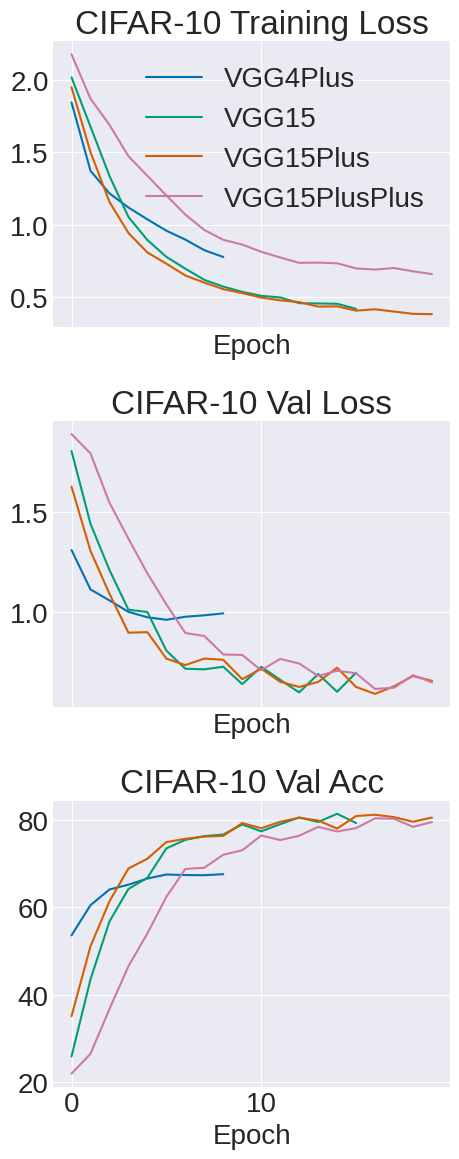

In [9]:
def plot_loss_acc_x3(train_losses, val_losses, val_accs, epochs,
                     net_names=['VGG15PlusPlus', 'VGG15', 'VGG15Plus', 'VGG4Plus']):
    '''Makes a 3x1 plot of the training losses, val losses, and val accs for the 4 nets.

    This complete function is provided to you. Feel free to modify if necessary.

    Parameters:
    -----------
    train_losses: Python list of list. len(train_losses)=4.
        List of the training loss histories of the 4 nets.
    val_losses: Python list of list. len(val_losses)=4.
        List of the val loss histories of the 4 nets.
    val_accs: Python list of list. len(val_accs)=4.
        List of the val accuracy histories of the 4 nets.
    epochs: Python list of int. len(epochs)=4.
        The number of epochs used to train each network.
    net_names: Python list of str. len(epochs)=4.
        The string name of the networks. The order must correspond to the order of the loss and acc lists.
    '''
    fig, axes = plt.subplots(ncols=1, nrows=3, sharex=True, figsize=(5, 12))

    titles = ['CIFAR-10 Training Loss', 'CIFAR-10 Val Loss', 'CIFAR-10 Val Acc']
    xlabels = 3*['Epoch']
    data = [train_losses, val_losses, val_accs]

    for i in range(len(titles)):
        curr_hist = data[i]

        for n in range(len(net_names)):
            curr_data = np.copy(np.array(curr_hist[n]))

            if 'acc' in titles[i].lower():
                curr_data = 100*curr_data[:epochs[n]]

            axes[i].plot(curr_data, label=net_names[n])

        axes[i].set_xlabel(xlabels[i])
        # axes[i].set_ylabel(ylabels[i])
        axes[i].set_title(titles[i])

        if i == 0:
            axes[i].legend()

    plt.tight_layout()
    plt.show()

plot_loss_acc_x3(train_losses, val_losses, val_accs, epochs, net_names)

### 9e. Questions

**Question 13** How does the runtime (per epoch) of the networks with batch normalization compare without it (e.g. `VGG15` vs. `VGG15Plus`)? 

**Answer 13:** The runtime (per epoch) with batch normalization was faster than without it.

## Task 10. Learning rate decay

The classification accuracy of the networks with batch normalization may seem a little underwhelming...but we can change that! A synergistic tool to potentially unlock improved classification accuracy is **learning rate decay.** We will adopt the simple approach of multiplicatively adjusting the learning rate. That is:

$$
\eta_{new} = d \times \eta_{curr}
$$

where $\eta$ is the learning rate and $d$ is a float between 0.0 and 1.0. This learning rate update does not occur on every epoch — it only gets applied when the validation loss stops improving for some number of epochs (i.e. the learning rate patience). This means we add and maintain an independent early stopping process dedicated to the learning rate.

Let's add this to the training workflow then revisit the performance of the networks with batch normalization.

In [107]:
from vgg_nets import VGG15PlusPlus, VGG15, VGG15Plus, VGG4Plus

### 10a. Add support for learning rate decay in `DeepNetwork`

Follow the procedure outlined in class add learning rate decay to the training workflow. Here is a brief summary:
1. Implement `update_lr(lr_decay_rate)` to multiplicatively adjust the optimizer's learning rate.
2. In `fit`, create a separate new empty list before the training loop to represent the rolling validation loss related to the learning rate decay process.
3. In `fit`, adjacent to where you check early stopping for training epochs, check "early stopping" for learning rate. If "early stopping" is triggered for the learning rate, decrease the learning rate. Only decrease the learning rate a preset number of times (`lr_max_decays`).

In [13]:
from layers import Dense
from network import DeepNetwork

#### Test: Learning rate decay

The following test trains a single layer softmax network on Iris. If everything is working as expected, you should see:
- learning rate decays from 0.1 to 0.05 during epoch 6.
- learning rate decays from 0.05 to 0.025 during epoch 25.
- learning rate decays from 0.025 to 0.0125 during epoch 39.
- learning rate decays from 0.0125 to 0.00625 during epoch 53.
- training ends after 65 epochs.

**Note:** If you do not get these exact results, that could be fine. What you are looking for is a drop in the learning rate when the val loss does not improve/decrease within a window of 3 epochs.

In [14]:
# Quickly make a mock network for testing
class SoftmaxNet(DeepNetwork):
    def __init__(self, input_feats_shape, C, reg=0):
        super().__init__(input_feats_shape, reg)
        self.output_layer = Dense('TestDense', units=C, activation='softmax', prev_layer_or_block=None)

    def __call__(self, x):
        return self.output_layer(x)

# Load in Iris train/validation sets
train_samps = tf.constant(np.load('data/iris/iris_train_samps.npy'), dtype=tf.float32)
train_labels = tf.constant(np.load('data/iris/iris_train_labels.npy'), dtype=tf.int32)
val_samps = tf.constant(np.load('data/iris/iris_val_samps.npy'), dtype=tf.float32)
val_labels = tf.constant(np.load('data/iris/iris_val_labels.npy'), dtype=tf.int32)

# Set some vars
C = 3
M = train_samps.shape[1]
mini_batch_sz = 25
lr = 1e-1
max_epochs = 5000
patience = 7
val_every = 1  # how often (in epochs) we check the val loss/acc/early stopping

# Create our test net
tf.random.set_seed(0)
slnet = SoftmaxNet((M,), C)
slnet.compile(lr=lr)

_, val_loss_hist, val_acc_hist, e = slnet.fit(train_samps, train_labels, val_samps, val_labels,
                                              batch_size=mini_batch_sz,
                                              max_epochs=max_epochs,
                                              patience=patience,
                                              val_every=val_every,
                                              lr_patience=3,
                                              lr_max_decays=4)

print(75*'-')
print(f'Iris test ended after {e} epochs with final val loss/acc of {val_loss_hist[-1]:.2f}/{val_acc_hist[-1]:.2f}')
print(75*'-')

---------------------------------------------------------------------------
Dense layer output(TestDense) shape: [1, 3]
---------------------------------------------------------------------------


Epoch 1: Training Loss = 1.1561, Validation Loss = 1.0572, Validation Accuracy = 0.6531
Epoch 1/5000 took 1.7280 seconds
Epoch 2: Training Loss = 0.8358, Validation Loss = 0.5779, Validation Accuracy = 0.6735
Epoch 2/5000 took 0.0092 seconds
Epoch 3: Training Loss = 0.6456, Validation Loss = 0.5150, Validation Accuracy = 0.6531
Epoch 3/5000 took 0.0082 seconds
Epoch 4: Training Loss = 0.5420, Validation Loss = 0.4582, Validation Accuracy = 0.6531
Epoch 4/5000 took 0.0095 seconds
Epoch 5: Training Loss = 0.4831, Validation Loss = 0.4446, Validation Accuracy = 0.6735
Epoch 5/5000 took 0.0084 seconds
Epoch 6: Training Loss = 0.3864, Validation Loss = 0.4211, Validation Accuracy = 0.6531
Epoch 6/5000 took 0.0086 seconds
Epoch 7: Training Loss = 0.4073, Validation Loss = 0.3679, Validation Accuracy = 0.8163
Epoch 7/5000 took 0.0084 seconds
Epoch 8: Training Loss = 0.3475, Validation Loss = 0.3580, Validation Accuracy = 0.8776
Epoch 8/5000 took 0.0095 seconds
Epoch 9: Training Loss = 0.3361,

Epoch 24: Training Loss = 0.2468, Validation Loss = 0.2191, Validation Accuracy = 0.9592
Epoch 24/5000 took 0.0104 seconds
Current lr= 0.05 Updated lr= 0.025
Epoch 25: Training Loss = 0.2089, Validation Loss = 0.2406, Validation Accuracy = 0.9388
Epoch 25/5000 took 0.0108 seconds
Epoch 26: Training Loss = 0.2123, Validation Loss = 0.2373, Validation Accuracy = 0.9388
Epoch 26/5000 took 0.0092 seconds
Epoch 27: Training Loss = 0.2161, Validation Loss = 0.2122, Validation Accuracy = 0.9592
Epoch 27/5000 took 0.0093 seconds
Epoch 28: Training Loss = 0.2273, Validation Loss = 0.2078, Validation Accuracy = 0.9592
Epoch 28/5000 took 0.0091 seconds
Epoch 29: Training Loss = 0.2590, Validation Loss = 0.2059, Validation Accuracy = 0.9592
Epoch 29/5000 took 0.0095 seconds
Epoch 30: Training Loss = 0.2298, Validation Loss = 0.2170, Validation Accuracy = 0.9592
Epoch 30/5000 took 0.0094 seconds
Current lr= 0.025 Updated lr= 0.0125
Epoch 31: Training Loss = 0.2003, Validation Loss = 0.2465, Validat

Epoch 46: Training Loss = 0.1865, Validation Loss = 0.2062, Validation Accuracy = 0.9592
Epoch 46/5000 took 0.0101 seconds
Epoch 47: Training Loss = 0.2540, Validation Loss = 0.2058, Validation Accuracy = 0.9592
Epoch 47/5000 took 0.0095 seconds
Epoch 48: Training Loss = 0.2091, Validation Loss = 0.2010, Validation Accuracy = 0.9592
Epoch 48/5000 took 0.0094 seconds
Epoch 49: Training Loss = 0.2230, Validation Loss = 0.1958, Validation Accuracy = 0.9592
Epoch 49/5000 took 0.0095 seconds
Epoch 50: Training Loss = 0.1856, Validation Loss = 0.1927, Validation Accuracy = 0.9796
Epoch 50/5000 took 0.0094 seconds
Epoch 51: Training Loss = 0.2401, Validation Loss = 0.1924, Validation Accuracy = 0.9796
Epoch 51/5000 took 0.0095 seconds
Epoch 52: Training Loss = 0.1915, Validation Loss = 0.1932, Validation Accuracy = 0.9796
Epoch 52/5000 took 0.0094 seconds
Epoch 53: Training Loss = 0.2002, Validation Loss = 0.1943, Validation Accuracy = 0.9592
Epoch 53/5000 took 0.0095 seconds
Epoch 54: Traini

Epoch 68: Training Loss = 0.2096, Validation Loss = 0.1934, Validation Accuracy = 0.9592
Epoch 68/5000 took 0.0108 seconds
Epoch 69: Training Loss = 0.2190, Validation Loss = 0.1884, Validation Accuracy = 0.9592
Epoch 69/5000 took 0.0096 seconds
Epoch 70: Training Loss = 0.2327, Validation Loss = 0.1842, Validation Accuracy = 0.9796
Epoch 70/5000 took 0.0096 seconds
Epoch 71: Training Loss = 0.1723, Validation Loss = 0.1834, Validation Accuracy = 0.9796
Epoch 71/5000 took 0.0098 seconds
Epoch 72: Training Loss = 0.2002, Validation Loss = 0.1831, Validation Accuracy = 0.9796
Epoch 72/5000 took 0.0096 seconds
Epoch 73: Training Loss = 0.2198, Validation Loss = 0.1830, Validation Accuracy = 0.9796
Epoch 73/5000 took 0.0097 seconds
Epoch 74: Training Loss = 0.1617, Validation Loss = 0.1843, Validation Accuracy = 0.9796
Epoch 74/5000 took 0.0096 seconds
Epoch 75: Training Loss = 0.2016, Validation Loss = 0.1876, Validation Accuracy = 0.9592
Epoch 75/5000 took 0.0096 seconds
Epoch 76: Traini

### 10b. Train VGG nets with batch normalization redux

Repeat the training session you performed in the previous task involving the "plus networks" on CIFAR-10:
- VGG4Plus
- VGG15
- VGG15Plus
- VGG15PlusPlus

Use default hyperparameters except:
- Use AdamW optimizer.
- Use He initialization
- Use a patience of `15`.
- Use a learning rate patience of 4.

After training each net, store/record:
1. the network's final test accuracy.
2. the history of training loss (averaged across mini-batches, so one per epoch).
3. the history of validation loss (checked every epoch).
4. the history of validation accuracy (checked every epoch).

**Notes:**
- Set random seed before creating each net for consistency.
- Use `tf.keras.backend.clear_session()` before creating each of the network to help prevent the memory used from growing.

Training these networks should take a few hours. Your VGG15PlusPlus network should achieve the best results and shatter your previous CIFAR-10 val/test accuracy record by a substantial margin.

In [10]:
net_names = ['VGG4Plus', 'VGG15', 'VGG15Plus', 'VGG15PlusPlus']
train_losses = []
val_losses = []
val_accs = []
epochs = []
accs = []

for net_name in net_names:
    tf.keras.backend.clear_session()
    tf.random.set_seed(0)

    if net_name == 'VGG4Plus':
        model = VGG4Plus(10, (32, 32, 3))
    elif net_name == 'VGG15':
        model = VGG15(10, (32, 32, 3))
    elif net_name == 'VGG15Plus':
        model = VGG15Plus(10, (32, 32, 3))
    elif net_name == 'VGG15PlusPlus':
        model = VGG15PlusPlus(10, (32, 32, 3))

    model.compile(optimizer='adamw')
    train_loss_hist, val_loss_hist, val_acc_hist, num_epochs = model.fit(x_train, y_train, x_val, y_val, patience=15, lr_patience=4)
    test_acc = model.evaluate(x_test, y_test)[0]

    train_losses.append(train_loss_hist)
    val_losses.append(val_loss_hist)
    val_accs.append(val_acc_hist)
    epochs.append(num_epochs)
    accs.append(test_acc)

---------------------------------------------------------------------------
Dense layer output(output) shape: [1, 10]
Dropout layer output(dropout1) shape: [1, 128]
Dense layer output(dense1) shape: [1, 128]
Flatten layer output(flat) shape: [1, 16384]
MaxPool2D layer output(maxpool1) shape: [1, 16, 16, 64]
Conv2D layer output(conv2) shape: [1, 32, 32, 64]
Conv2D layer output(conv1) shape: [1, 32, 32, 64]
---------------------------------------------------------------------------


Epoch 1: Training Loss = 1.8380, Validation Loss = 1.2943, Validation Accuracy = 0.5323
Epoch 1/10000 took 4.5928 seconds


Epoch 2: Training Loss = 1.3168, Validation Loss = 1.1666, Validation Accuracy = 0.5950
Epoch 2/10000 took 2.0162 seconds


Epoch 3: Training Loss = 1.1379, Validation Loss = 1.0178, Validation Accuracy = 0.6450
Epoch 3/10000 took 1.9993 seconds


Epoch 4: Training Loss = 1.0124, Validation Loss = 0.9804, Validation Accuracy = 0.6587
Epoch 4/10000 took 2.0461 seconds


Epoch 5: Training Loss = 0.9199, Validation Loss = 0.9531, Validation Accuracy = 0.6723
Epoch 5/10000 took 2.0152 seconds


Epoch 6: Training Loss = 0.8378, Validation Loss = 0.9431, Validation Accuracy = 0.6791
Epoch 6/10000 took 2.0180 seconds


Epoch 7: Training Loss = 0.7736, Validation Loss = 0.9362, Validation Accuracy = 0.6837
Epoch 7/10000 took 2.0216 seconds


Epoch 8: Training Loss = 0.7030, Validation Loss = 0.9561, Validation Accuracy = 0.6865
Epoch 8/10000 took 2.0211 seconds


Epoch 9: Training Loss = 0.6522, Validation Loss = 0.9788, Validation Accuracy = 0.6953
Epoch 9/10000 took 2.0360 seconds


Current lr= 0.001 Updated lr= 0.0005
Epoch 10: Training Loss = 0.5989, Validation Loss = 1.0114, Validation Accuracy = 0.6887
Epoch 10/10000 took 2.0214 seconds


Epoch 11: Training Loss = 0.5198, Validation Loss = 1.0105, Validation Accuracy = 0.6973
Epoch 11/10000 took 2.0211 seconds


Epoch 12: Training Loss = 0.4740, Validation Loss = 1.0251, Validation Accuracy = 0.7025
Epoch 12/10000 took 2.0144 seconds


Epoch 13: Training Loss = 0.4347, Validation Loss = 1.0721, Validation Accuracy = 0.7053
Epoch 13/10000 took 2.0106 seconds


Epoch 14: Training Loss = 0.4051, Validation Loss = 1.0830, Validation Accuracy = 0.6997
Epoch 14/10000 took 2.0261 seconds


Current lr= 0.0005 Updated lr= 0.00025
Epoch 15: Training Loss = 0.3949, Validation Loss = 1.1253, Validation Accuracy = 0.6985
Epoch 15/10000 took 2.0252 seconds


Epoch 16: Training Loss = 0.3519, Validation Loss = 1.1346, Validation Accuracy = 0.7063
Epoch 16/10000 took 2.0242 seconds


Epoch 17: Training Loss = 0.3303, Validation Loss = 1.1871, Validation Accuracy = 0.7001
Epoch 17/10000 took 2.0202 seconds


Epoch 18: Training Loss = 0.3156, Validation Loss = 1.2109, Validation Accuracy = 0.7017
Epoch 18/10000 took 2.0116 seconds


Epoch 19: Training Loss = 0.3068, Validation Loss = 1.2312, Validation Accuracy = 0.7003
Epoch 19/10000 took 2.0211 seconds


Current lr= 0.00025 Updated lr= 0.000125
Epoch 20: Training Loss = 0.2919, Validation Loss = 1.2665, Validation Accuracy = 0.7045
Epoch 20/10000 took 2.0178 seconds


Epoch 21: Training Loss = 0.2742, Validation Loss = 1.2601, Validation Accuracy = 0.7073
Early stopping triggered at epoch 21
Finished training after 21 epochs!


---------------------------------------------------------------------------
Dense layer output(output_layer) shape: [1, 10]
DenseBlock1:
	Dropout layer output(DenseBlock1/dropout) shape: [1, 512]
	Dense layer output(DenseBlock1/dense_0) shape: [1, 512]
Flatten layer output(flat) shape: [1, 512]
ConvBlock5:
	MaxPool2D layer output(ConvBlock5/maxpool2) shape: [1, 1, 1, 512]
	Conv2D layer output(ConvBlock5/conv_2) shape: [1, 2, 2, 512]
	Conv2D layer output(ConvBlock5/conv_1) shape: [1, 2, 2, 512]
	Conv2D layer output(ConvBlock5/conv_0) shape: [1, 2, 2, 512]
ConvBlock4:
	MaxPool2D layer output(ConvBlock4/maxpool2) shape: [1, 2, 2, 512]
	Conv2D layer output(ConvBlock4/conv_2) shape: [1, 4, 4, 512]
	Conv2D layer output(ConvBlock4/conv_1) shape: [1, 4, 4, 512]
	Conv2D layer output(ConvBlock4/conv_0) shape: [1, 4, 4, 512]
ConvBlock3:
	MaxPool2D layer output(ConvBlock3/maxpool2) shape: [1, 4, 4, 256]
	Conv2D layer output(ConvBlock3/conv_2) shape: [1, 8, 8, 256]
	Conv2D layer output(ConvBlock3/c

Epoch 1: Training Loss = 1.9780, Validation Loss = 1.6483, Validation Accuracy = 0.3381
Epoch 1/10000 took 14.5340 seconds


Epoch 2: Training Loss = 1.4917, Validation Loss = 1.3703, Validation Accuracy = 0.4838
Epoch 2/10000 took 8.0881 seconds


Epoch 3: Training Loss = 1.2092, Validation Loss = 1.0643, Validation Accuracy = 0.6238
Epoch 3/10000 took 8.0855 seconds


Epoch 4: Training Loss = 0.9778, Validation Loss = 0.8898, Validation Accuracy = 0.6877
Epoch 4/10000 took 8.0656 seconds


Epoch 5: Training Loss = 0.8500, Validation Loss = 0.9012, Validation Accuracy = 0.6995
Epoch 5/10000 took 8.0585 seconds


Epoch 6: Training Loss = 0.7572, Validation Loss = 0.7923, Validation Accuracy = 0.7258
Epoch 6/10000 took 8.0464 seconds


Epoch 7: Training Loss = 0.6884, Validation Loss = 0.7126, Validation Accuracy = 0.7576
Epoch 7/10000 took 8.0463 seconds


Epoch 8: Training Loss = 0.6142, Validation Loss = 0.7621, Validation Accuracy = 0.7570
Epoch 8/10000 took 8.0384 seconds


Epoch 9: Training Loss = 0.5869, Validation Loss = 0.6898, Validation Accuracy = 0.7694
Epoch 9/10000 took 8.0501 seconds


Epoch 10: Training Loss = 0.5421, Validation Loss = 0.6896, Validation Accuracy = 0.7776
Epoch 10/10000 took 8.0559 seconds


Epoch 11: Training Loss = 0.5098, Validation Loss = 0.6242, Validation Accuracy = 0.7983
Epoch 11/10000 took 8.0436 seconds


Epoch 12: Training Loss = 0.4878, Validation Loss = 0.6249, Validation Accuracy = 0.8007
Epoch 12/10000 took 8.0655 seconds


Epoch 13: Training Loss = 0.4732, Validation Loss = 0.7140, Validation Accuracy = 0.7762
Epoch 13/10000 took 8.0627 seconds


Epoch 14: Training Loss = 0.4493, Validation Loss = 0.6185, Validation Accuracy = 0.8117
Epoch 14/10000 took 8.0643 seconds


Epoch 15: Training Loss = 0.4459, Validation Loss = 0.6478, Validation Accuracy = 0.7937
Epoch 15/10000 took 8.0696 seconds


Epoch 16: Training Loss = 0.4326, Validation Loss = 0.6171, Validation Accuracy = 0.8147
Epoch 16/10000 took 8.0770 seconds


Epoch 17: Training Loss = 0.4195, Validation Loss = 0.6406, Validation Accuracy = 0.8077
Epoch 17/10000 took 8.0735 seconds


Epoch 18: Training Loss = 0.3997, Validation Loss = 0.6701, Validation Accuracy = 0.7913
Epoch 18/10000 took 8.0679 seconds


Current lr= 0.001 Updated lr= 0.0005
Epoch 19: Training Loss = 0.4120, Validation Loss = 0.7273, Validation Accuracy = 0.7774
Epoch 19/10000 took 8.0717 seconds


Epoch 20: Training Loss = 0.2410, Validation Loss = 0.5353, Validation Accuracy = 0.8371
Epoch 20/10000 took 8.0680 seconds


Epoch 21: Training Loss = 0.2001, Validation Loss = 0.5983, Validation Accuracy = 0.8323
Epoch 21/10000 took 8.0826 seconds


Epoch 22: Training Loss = 0.1961, Validation Loss = 0.6235, Validation Accuracy = 0.8315
Epoch 22/10000 took 8.0778 seconds


Epoch 23: Training Loss = 0.1893, Validation Loss = 0.6024, Validation Accuracy = 0.8359
Epoch 23/10000 took 8.0651 seconds


Epoch 24: Training Loss = 0.1872, Validation Loss = 0.5671, Validation Accuracy = 0.8369
Epoch 24/10000 took 8.0832 seconds


Epoch 25: Training Loss = 0.1763, Validation Loss = 0.6321, Validation Accuracy = 0.8295
Epoch 25/10000 took 8.0762 seconds


Epoch 26: Training Loss = 0.1760, Validation Loss = 0.5782, Validation Accuracy = 0.8417
Epoch 26/10000 took 8.0791 seconds


Current lr= 0.0005 Updated lr= 0.00025
Epoch 27: Training Loss = 0.1735, Validation Loss = 0.6867, Validation Accuracy = 0.8191
Epoch 27/10000 took 8.0877 seconds


Epoch 28: Training Loss = 0.0766, Validation Loss = 0.6563, Validation Accuracy = 0.8496
Epoch 28/10000 took 8.0863 seconds


Epoch 29: Training Loss = 0.0547, Validation Loss = 0.7740, Validation Accuracy = 0.8373
Epoch 29/10000 took 8.0982 seconds


Epoch 30: Training Loss = 0.0646, Validation Loss = 0.6748, Validation Accuracy = 0.8423
Epoch 30/10000 took 8.0949 seconds


Epoch 31: Training Loss = 0.0676, Validation Loss = 0.6897, Validation Accuracy = 0.8345
Epoch 31/10000 took 8.1054 seconds


Epoch 32: Training Loss = 0.0625, Validation Loss = 0.6826, Validation Accuracy = 0.8438
Epoch 32/10000 took 8.1100 seconds


Current lr= 0.00025 Updated lr= 0.000125
Epoch 33: Training Loss = 0.0601, Validation Loss = 0.6924, Validation Accuracy = 0.8355
Epoch 33/10000 took 8.1085 seconds


Epoch 34: Training Loss = 0.0210, Validation Loss = 0.7288, Validation Accuracy = 0.8532
Early stopping triggered at epoch 34
Finished training after 34 epochs!


---------------------------------------------------------------------------
Dense layer output(output_layer) shape: [1, 10]
DenseBlock1:
	Dropout layer output(DenseBlock1/dropout) shape: [1, 512]
	Dense layer output(DenseBlock1/dense_0) shape: [1, 512]
Flatten layer output(flat) shape: [1, 512]
ConvBlock5:
	MaxPool2D layer output(ConvBlock5/maxpool2) shape: [1, 1, 1, 512]
	Conv2D layer output(ConvBlock5/conv_2) shape: [1, 2, 2, 512]
	Conv2D layer output(ConvBlock5/conv_1) shape: [1, 2, 2, 512]
	Conv2D layer output(ConvBlock5/conv_0) shape: [1, 2, 2, 512]
ConvBlock4:
	MaxPool2D layer output(ConvBlock4/maxpool2) shape: [1, 2, 2, 512]
	Conv2D layer output(ConvBlock4/conv_2) shape: [1, 4, 4, 512]
	Conv2D layer output(ConvBlock4/conv_1) shape: [1, 4, 4, 512]
	Conv2D layer output(ConvBlock4/conv_0) shape: [1, 4, 4, 512]
ConvBlock3:
	MaxPool2D layer output(ConvBlock3/maxpool2) shape: [1, 4, 4, 256]
	Conv2D layer output(ConvBlock3/conv_2) shape: [1, 8, 8, 256]
	Conv2D layer output(ConvBlock3/c

Epoch 1: Training Loss = 2.3084, Validation Loss = 2.1784, Validation Accuracy = 0.1855
Epoch 1/10000 took 14.5647 seconds


Epoch 2: Training Loss = 1.9074, Validation Loss = 1.7603, Validation Accuracy = 0.2718
Epoch 2/10000 took 8.0616 seconds


Epoch 3: Training Loss = 1.6185, Validation Loss = 1.4398, Validation Accuracy = 0.4341
Epoch 3/10000 took 8.0798 seconds


Epoch 4: Training Loss = 1.3051, Validation Loss = 1.2376, Validation Accuracy = 0.5543
Epoch 4/10000 took 8.0748 seconds


Epoch 5: Training Loss = 1.0661, Validation Loss = 1.0571, Validation Accuracy = 0.6342
Epoch 5/10000 took 8.0576 seconds


Epoch 6: Training Loss = 0.9170, Validation Loss = 0.9134, Validation Accuracy = 0.6715
Epoch 6/10000 took 8.0506 seconds


Epoch 7: Training Loss = 0.7936, Validation Loss = 0.7407, Validation Accuracy = 0.7416
Epoch 7/10000 took 8.0275 seconds


Epoch 8: Training Loss = 0.7032, Validation Loss = 0.7401, Validation Accuracy = 0.7512
Epoch 8/10000 took 8.0168 seconds


Epoch 9: Training Loss = 0.6378, Validation Loss = 0.7958, Validation Accuracy = 0.7358
Epoch 9/10000 took 8.0169 seconds


Epoch 10: Training Loss = 0.6005, Validation Loss = 0.6864, Validation Accuracy = 0.7758
Epoch 10/10000 took 8.0141 seconds


Epoch 11: Training Loss = 0.5521, Validation Loss = 0.7008, Validation Accuracy = 0.7722
Epoch 11/10000 took 8.0019 seconds


Epoch 12: Training Loss = 0.5372, Validation Loss = 0.6434, Validation Accuracy = 0.7949
Epoch 12/10000 took 7.9964 seconds


Epoch 13: Training Loss = 0.5012, Validation Loss = 0.6742, Validation Accuracy = 0.7913
Epoch 13/10000 took 8.0234 seconds


Epoch 14: Training Loss = 0.4858, Validation Loss = 0.7366, Validation Accuracy = 0.7734
Epoch 14/10000 took 8.0128 seconds


Epoch 15: Training Loss = 0.4747, Validation Loss = 0.6385, Validation Accuracy = 0.8019
Epoch 15/10000 took 8.0400 seconds


Epoch 16: Training Loss = 0.4548, Validation Loss = 0.6260, Validation Accuracy = 0.7999
Epoch 16/10000 took 8.0307 seconds


Epoch 17: Training Loss = 0.4387, Validation Loss = 0.6429, Validation Accuracy = 0.7833
Epoch 17/10000 took 8.0424 seconds


Epoch 18: Training Loss = 0.4448, Validation Loss = 0.7026, Validation Accuracy = 0.7891
Epoch 18/10000 took 8.0321 seconds


Current lr= 0.001 Updated lr= 0.0005
Epoch 19: Training Loss = 0.4235, Validation Loss = 0.6276, Validation Accuracy = 0.7971
Epoch 19/10000 took 8.0423 seconds


Epoch 20: Training Loss = 0.2636, Validation Loss = 0.5557, Validation Accuracy = 0.8367
Epoch 20/10000 took 8.0533 seconds


Epoch 21: Training Loss = 0.2234, Validation Loss = 0.5881, Validation Accuracy = 0.8275
Epoch 21/10000 took 8.0563 seconds


Epoch 22: Training Loss = 0.2128, Validation Loss = 0.6023, Validation Accuracy = 0.8291
Epoch 22/10000 took 8.1383 seconds


Epoch 23: Training Loss = 0.2147, Validation Loss = 0.5976, Validation Accuracy = 0.8309
Epoch 23/10000 took 8.0468 seconds


Epoch 24: Training Loss = 0.1933, Validation Loss = 0.5711, Validation Accuracy = 0.8307
Epoch 24/10000 took 8.0479 seconds


Epoch 25: Training Loss = 0.2030, Validation Loss = 0.6268, Validation Accuracy = 0.8231
Epoch 25/10000 took 8.0598 seconds


Epoch 26: Training Loss = 0.1940, Validation Loss = 0.6074, Validation Accuracy = 0.8323
Epoch 26/10000 took 8.0537 seconds


Current lr= 0.0005 Updated lr= 0.00025
Epoch 27: Training Loss = 0.1880, Validation Loss = 0.6665, Validation Accuracy = 0.8217
Epoch 27/10000 took 8.0576 seconds


Epoch 28: Training Loss = 0.0841, Validation Loss = 0.6029, Validation Accuracy = 0.8530
Epoch 28/10000 took 8.0455 seconds


Epoch 29: Training Loss = 0.0666, Validation Loss = 0.6281, Validation Accuracy = 0.8470
Epoch 29/10000 took 8.0592 seconds


Epoch 30: Training Loss = 0.0651, Validation Loss = 0.6817, Validation Accuracy = 0.8490
Epoch 30/10000 took 8.0573 seconds


Epoch 31: Training Loss = 0.0678, Validation Loss = 0.6368, Validation Accuracy = 0.8492
Epoch 31/10000 took 8.0612 seconds


Current lr= 0.00025 Updated lr= 0.000125
Epoch 32: Training Loss = 0.0691, Validation Loss = 0.6480, Validation Accuracy = 0.8393
Epoch 32/10000 took 8.0643 seconds


Epoch 33: Training Loss = 0.0236, Validation Loss = 0.6491, Validation Accuracy = 0.8642
Epoch 33/10000 took 8.0729 seconds


Epoch 34: Training Loss = 0.0139, Validation Loss = 0.6645, Validation Accuracy = 0.8638
Early stopping triggered at epoch 34
Finished training after 34 epochs!


---------------------------------------------------------------------------
Dense layer output(output_layer) shape: [1, 10]
DenseBlock1:
	Dropout layer output(DenseBlock1/dropout) shape: [1, 512]
	Dense layer output(DenseBlock1/dense_0) shape: [1, 512]
Flatten layer output(flat) shape: [1, 512]
ConvBlock5:
	Dropout layer output(ConvBlock5/dropout) shape: [1, 1, 1, 512]
	MaxPool2D layer output(ConvBlock5/maxpool2) shape: [1, 1, 1, 512]
	Conv2D layer output(ConvBlock5/conv_2) shape: [1, 2, 2, 512]
	Conv2D layer output(ConvBlock5/conv_1) shape: [1, 2, 2, 512]
	Conv2D layer output(ConvBlock5/conv_0) shape: [1, 2, 2, 512]
ConvBlock4:
	Dropout layer output(ConvBlock4/dropout) shape: [1, 2, 2, 512]
	MaxPool2D layer output(ConvBlock4/maxpool2) shape: [1, 2, 2, 512]
	Conv2D layer output(ConvBlock4/conv_2) shape: [1, 4, 4, 512]
	Conv2D layer output(ConvBlock4/conv_1) shape: [1, 4, 4, 512]
	Conv2D layer output(ConvBlock4/conv_0) shape: [1, 4, 4, 512]
ConvBlock3:
	Dropout layer output(ConvBlock3/d

Epoch 1: Training Loss = 2.1111, Validation Loss = 1.8847, Validation Accuracy = 0.2173
Epoch 1/10000 took 17.8541 seconds


Epoch 2: Training Loss = 1.7792, Validation Loss = 1.5911, Validation Accuracy = 0.3628
Epoch 2/10000 took 8.2313 seconds


Epoch 3: Training Loss = 1.5563, Validation Loss = 1.6096, Validation Accuracy = 0.4099
Epoch 3/10000 took 8.2615 seconds


Epoch 4: Training Loss = 1.3797, Validation Loss = 1.1477, Validation Accuracy = 0.5733
Epoch 4/10000 took 8.2653 seconds


Epoch 5: Training Loss = 1.2305, Validation Loss = 1.1186, Validation Accuracy = 0.5964
Epoch 5/10000 took 8.2559 seconds


Epoch 6: Training Loss = 1.1035, Validation Loss = 0.9991, Validation Accuracy = 0.6490
Epoch 6/10000 took 8.2162 seconds


Epoch 7: Training Loss = 0.9918, Validation Loss = 0.8634, Validation Accuracy = 0.7013
Epoch 7/10000 took 8.2280 seconds


Epoch 8: Training Loss = 0.9290, Validation Loss = 0.8551, Validation Accuracy = 0.7099
Epoch 8/10000 took 8.2023 seconds


Epoch 9: Training Loss = 0.8819, Validation Loss = 0.8519, Validation Accuracy = 0.7099
Epoch 9/10000 took 8.1894 seconds


Epoch 10: Training Loss = 0.8282, Validation Loss = 0.7631, Validation Accuracy = 0.7374
Epoch 10/10000 took 8.1701 seconds


Epoch 11: Training Loss = 0.8001, Validation Loss = 0.7087, Validation Accuracy = 0.7698
Epoch 11/10000 took 8.1715 seconds


Epoch 12: Training Loss = 0.7582, Validation Loss = 0.6813, Validation Accuracy = 0.7754
Epoch 12/10000 took 8.1867 seconds


Epoch 13: Training Loss = 0.7578, Validation Loss = 0.6782, Validation Accuracy = 0.7786
Epoch 13/10000 took 8.1828 seconds


Epoch 14: Training Loss = 0.7226, Validation Loss = 0.7040, Validation Accuracy = 0.7654
Epoch 14/10000 took 8.1734 seconds


Epoch 15: Training Loss = 0.7122, Validation Loss = 0.6775, Validation Accuracy = 0.7812
Epoch 15/10000 took 8.2005 seconds


Epoch 16: Training Loss = 0.6862, Validation Loss = 0.6224, Validation Accuracy = 0.7985
Epoch 16/10000 took 8.1974 seconds


Epoch 17: Training Loss = 0.6837, Validation Loss = 0.6215, Validation Accuracy = 0.8001
Epoch 17/10000 took 8.1986 seconds


Epoch 18: Training Loss = 0.6808, Validation Loss = 0.6136, Validation Accuracy = 0.7979
Epoch 18/10000 took 8.2188 seconds


Epoch 19: Training Loss = 0.6550, Validation Loss = 0.6147, Validation Accuracy = 0.8021
Epoch 19/10000 took 8.2041 seconds


Epoch 20: Training Loss = 0.6492, Validation Loss = 0.6099, Validation Accuracy = 0.8001
Epoch 20/10000 took 8.2052 seconds


Epoch 21: Training Loss = 0.6443, Validation Loss = 0.6384, Validation Accuracy = 0.7935
Epoch 21/10000 took 8.2020 seconds


Epoch 22: Training Loss = 0.6394, Validation Loss = 0.5958, Validation Accuracy = 0.8107
Epoch 22/10000 took 8.2124 seconds


Epoch 23: Training Loss = 0.6249, Validation Loss = 0.7592, Validation Accuracy = 0.7604
Epoch 23/10000 took 8.2165 seconds


Epoch 24: Training Loss = 0.6366, Validation Loss = 0.5860, Validation Accuracy = 0.8107
Epoch 24/10000 took 8.1980 seconds


Epoch 25: Training Loss = 0.6179, Validation Loss = 0.6256, Validation Accuracy = 0.8013
Epoch 25/10000 took 8.1926 seconds


Epoch 26: Training Loss = 0.6274, Validation Loss = 0.6196, Validation Accuracy = 0.8043
Epoch 26/10000 took 8.2008 seconds


Current lr= 0.001 Updated lr= 0.0005
Epoch 27: Training Loss = 0.6188, Validation Loss = 0.6268, Validation Accuracy = 0.8057
Epoch 27/10000 took 8.2036 seconds


Epoch 28: Training Loss = 0.4746, Validation Loss = 0.5020, Validation Accuracy = 0.8425
Epoch 28/10000 took 8.1998 seconds


Epoch 29: Training Loss = 0.4539, Validation Loss = 0.4838, Validation Accuracy = 0.8492
Epoch 29/10000 took 8.2200 seconds


Epoch 30: Training Loss = 0.4414, Validation Loss = 0.5029, Validation Accuracy = 0.8381
Epoch 30/10000 took 8.2109 seconds


Epoch 31: Training Loss = 0.4384, Validation Loss = 0.5352, Validation Accuracy = 0.8387
Epoch 31/10000 took 8.2098 seconds


Epoch 32: Training Loss = 0.4388, Validation Loss = 0.4824, Validation Accuracy = 0.8456
Epoch 32/10000 took 8.2082 seconds


Epoch 33: Training Loss = 0.4412, Validation Loss = 0.5341, Validation Accuracy = 0.8343
Epoch 33/10000 took 8.2038 seconds


Epoch 34: Training Loss = 0.4267, Validation Loss = 0.4809, Validation Accuracy = 0.8446
Epoch 34/10000 took 8.2186 seconds


Epoch 35: Training Loss = 0.4253, Validation Loss = 0.4876, Validation Accuracy = 0.8502
Epoch 35/10000 took 8.2261 seconds


Epoch 36: Training Loss = 0.4175, Validation Loss = 0.5516, Validation Accuracy = 0.8219
Epoch 36/10000 took 8.2180 seconds


Current lr= 0.0005 Updated lr= 0.00025
Epoch 37: Training Loss = 0.4117, Validation Loss = 0.5213, Validation Accuracy = 0.8325
Epoch 37/10000 took 8.2306 seconds


Epoch 38: Training Loss = 0.3177, Validation Loss = 0.4319, Validation Accuracy = 0.8612
Epoch 38/10000 took 8.2230 seconds


Epoch 39: Training Loss = 0.3007, Validation Loss = 0.4193, Validation Accuracy = 0.8706
Epoch 39/10000 took 8.2226 seconds


Epoch 40: Training Loss = 0.2943, Validation Loss = 0.4453, Validation Accuracy = 0.8692
Epoch 40/10000 took 8.2223 seconds


Epoch 41: Training Loss = 0.2892, Validation Loss = 0.4237, Validation Accuracy = 0.8724
Epoch 41/10000 took 8.2209 seconds


Current lr= 0.00025 Updated lr= 0.000125
Epoch 42: Training Loss = 0.2913, Validation Loss = 0.4605, Validation Accuracy = 0.8600
Epoch 42/10000 took 8.2257 seconds


Epoch 43: Training Loss = 0.2398, Validation Loss = 0.4084, Validation Accuracy = 0.8768
Epoch 43/10000 took 8.2160 seconds


Epoch 44: Training Loss = 0.2204, Validation Loss = 0.4011, Validation Accuracy = 0.8804
Epoch 44/10000 took 8.2153 seconds


Epoch 45: Training Loss = 0.2189, Validation Loss = 0.4146, Validation Accuracy = 0.8780
Epoch 45/10000 took 8.2237 seconds


Epoch 46: Training Loss = 0.2086, Validation Loss = 0.3860, Validation Accuracy = 0.8890
Epoch 46/10000 took 8.2247 seconds


Epoch 47: Training Loss = 0.2098, Validation Loss = 0.4170, Validation Accuracy = 0.8744
Epoch 47/10000 took 8.2191 seconds


Epoch 48: Training Loss = 0.2051, Validation Loss = 0.4169, Validation Accuracy = 0.8774
Epoch 48/10000 took 8.2148 seconds


Current lr= 0.000125 Updated lr= 6.25e-05
Epoch 49: Training Loss = 0.1952, Validation Loss = 0.4145, Validation Accuracy = 0.8790
Epoch 49/10000 took 8.2238 seconds


Epoch 50: Training Loss = 0.1649, Validation Loss = 0.4094, Validation Accuracy = 0.8810
Epoch 50/10000 took 8.2218 seconds


Epoch 51: Training Loss = 0.1634, Validation Loss = 0.3900, Validation Accuracy = 0.8866
Epoch 51/10000 took 8.2364 seconds


Epoch 52: Training Loss = 0.1556, Validation Loss = 0.3989, Validation Accuracy = 0.8848
Epoch 52/10000 took 8.2193 seconds


Epoch 53: Training Loss = 0.1524, Validation Loss = 0.4008, Validation Accuracy = 0.8886
Epoch 53/10000 took 8.2169 seconds


Current lr= 6.25e-05 Updated lr= 3.125e-05
Epoch 54: Training Loss = 0.1469, Validation Loss = 0.3915, Validation Accuracy = 0.8898
Epoch 54/10000 took 8.2216 seconds


Epoch 55: Training Loss = 0.1309, Validation Loss = 0.3869, Validation Accuracy = 0.8910
Epoch 55/10000 took 8.2170 seconds


Epoch 56: Training Loss = 0.1250, Validation Loss = 0.3888, Validation Accuracy = 0.8882
Epoch 56/10000 took 8.2502 seconds


Epoch 57: Training Loss = 0.1243, Validation Loss = 0.3933, Validation Accuracy = 0.8940
Epoch 57/10000 took 8.2376 seconds


Epoch 58: Training Loss = 0.1265, Validation Loss = 0.4073, Validation Accuracy = 0.8892
Epoch 58/10000 took 8.2382 seconds


Current lr= 3.125e-05 Updated lr= 1.5625e-05
Epoch 59: Training Loss = 0.1245, Validation Loss = 0.3941, Validation Accuracy = 0.8946
Epoch 59/10000 took 8.2280 seconds


Epoch 60: Training Loss = 0.1097, Validation Loss = 0.3997, Validation Accuracy = 0.8956
Early stopping triggered at epoch 60
Finished training after 60 epochs!


Adapt the following code to plot your findings. `plot_loss_acc_x3` is defined in the previous task above.

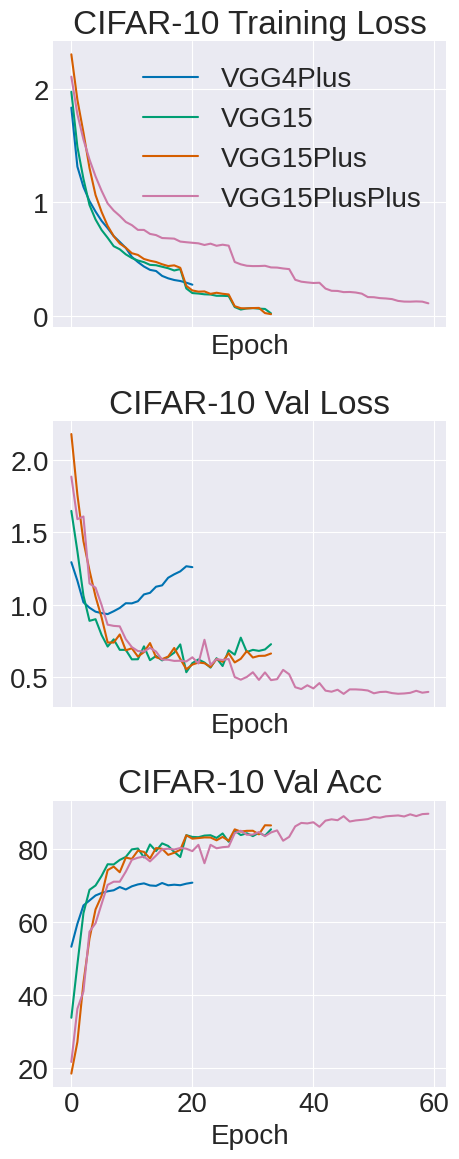

CIFAR-10 test accuracy:
VGG4Plus: 68.32%
VGG15: 85.38%
VGG15Plus: 85.13%
VGG15PlusPlus: 87.99%


In [11]:
plot_loss_acc_x3(train_losses, val_losses, val_accs, epochs, net_names)

print('CIFAR-10 test accuracy:')
for i in range(len(net_names)):
    print(f'{net_names[i]}: {100*accs[i]:.2f}%')

### 10c. Questions

**Question 14** What did the results of this experiment reveal about the relationship about network depth/size and classification accuracy? Please be specific.

**Question 15** Are there any downsides to the highest performing network (or is it just totally awesome :)?

**Answer 14:** The results showed that increasing network depth/size improves classification accuracy up to a point, but diminishing returns or overfitting may occur beyond a certain complexity.

**Answer 15:** The only downsides were increased training time and computational cost, but that shouldn't overshadow how impressive/awesome it is.

## Extensions

### General guidelines

1. Never integrate extensions into your base project so that they change the expected behavior of core functions. If your extension changes the core design/behavior, no problem, duplicate your working base project and add features from there.
2. Check the rubric to keep in mind how extensions on this project will be graded.
3. While I may consult your code and "written log" of what you did, **I am grading your extensions based on what you present in your 3-5 min video.**
3. I suggest documenting your explorations in a "log" or "lab notebook" style (i.e. documenting your thought/progression/discovery/learning process). I'm not grading your writing, so you can keep it succinct. **Whatever is most useful to you to remember what you did.** 
4. I suggest taking a hypothesis driven approach. For example "I was curious about X so I explored Y. I found Z, which was not what I expected because..., so then tried A..."
5. Make plots to help showcase your results.
6. **More is not necessarily better.** Generally, a small number of "in-depth" extensions count for more than many "shallow" extensions.

### AI guidelines

You may use AI in mostly any capacity for extensions. However, keep in mind:
1. There is no need to use AI at all!
2. You are welcome to use AI as a tool (e.g. automate something that is tedious, help you get unstuck, etc.). However, you should be coding, you should be thinking, you should be writing, you should be creating. If you are spending most (or even close to most) of your time typing into a chatbot and copy-pasting, you have probably gone too far with AI use.
3. I don't find large volumes of AI generated code/text/plots to be particularly impressive and you risk losing my interest while grading. Remember: I'm grading your extensions based on your video presentation. **More is not necessarily better.**

### Video guidelines

1. Please try to keep your video to 5 minutes (*I have other projects to grade!*). If you turn in a longer video, I make no promise that I will watch more than 5 minutes.
2. Your screen should be shared as you show me what you did. A live video of your face should also appear somewhere on the screen (e.g. picture-in-picture overlay / split screen).
3. Your partner should join you for the video and take turns talking, but, if necessary, it is fine to have one team member present during the record the video.
4. Do not simply read text from your notebook, do not read from a prepared script. I am not grading how polished your video presentation is (see extension grading criteria on rubric). 
5. I am looking for original and creative explorations sparked by your curiosity/interest/passion in a topic. This should be apparent in your video.
6. Be natural,, don't feel the need to impress me with fancy language. If it is helpful, imagine that we are talking one-on-one about your extension. Tell me what you did :)

### Extension ideas

#### 1. Tune hyperparameters to achieve even better classification accuracy

Try to squeeze out a few extra percent test accuracy!

#### 2. Other image datasets

You now have a family of fast, high performing neural networks ranging in size. Apply them to another dataset of your choice. 

#### 3. AlexNet

Research the original AlexNet architecture and create a network that implements it. *You may have to ignore a few "hacks" Krizhevsky and colleagues had to perform — as pioneers, they were operating at the absolute limit of what GPUs of the day could do!*

#### 4. Add support for saving/loading network weights

A key limitation of your current deep learning library is that parameters that capture the learning in networks are completely reset/lost/wiped out when the notebook kernel is terminated. Add (and test!) support for saving network parameters to disk after (or periodically during) training. Add (and test!) support for loading network parameters back into the network from disk before training. 

Be careful to include the moving mean and standard deviation parameters in batch normalization layers otherwise the whole net will not work!

#### 5. VGG15 vs. VGG16

VGG16 has another Block of Dense layers compared to VGG15. Additionally, the VGG nets in the paper use 4096 dense units per Dense layer (vs 512 in your nets). Is deeper and more units better? Try it out!